# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate correlated background but no synapse

In [6]:
######### Settings (need to run even if the data is already generated) #########
external_input_params = {
    "external_input_type": "two_peaks_with_all_varying",
    "std1": 10,
    "corr1": 0.5,
    "std2": 25,
    "corr2": 0.5,
    "use_two_modes": False,
    "gp_time_constant": 300,
    "gp_amplitude": 0.05,
}

conn = 0.0
nneuron_coupling = 10
nneuron = 100
nneuron_part = nneuron//2
npadding = 50

shared_background_list = [0.0, 0.2, 0.4]
nrep = 5

In [58]:
########## Generate synthetic data (no need to run) ###########

for shared_background in shared_background_list:
    for rep in range(nrep):
        spikes, trial_info, I_ext, I_syn = GLM.EIF_simulator(
            ntrial=2000,
            nneuron=nneuron,
            conn=conn,
            nneuron_coupling=nneuron_coupling,
            params=external_input_params,
            shared_background=shared_background,
            no_stimulus=False,
            return_trial_info=True,
            return_I_ext=True,
            return_I_syn=True,
        )
        file_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'
        np.savez_compressed(file_name,
                            spikes=spikes,
                            trial_info=trial_info,
                            I_ext=I_ext,
                            I_syn=I_syn)



100%|██████████| 2000/2000 [02:56<00:00, 11.34it/s]


# Our method and our method abalated

In [51]:
def fit_model(data_to_use, FIT_THE_BASELINE_MODEL):

    ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

    params = {
        # B-spline basis
        'num_B_spline_basis': 20,
        # Transformer VAE's settings
        'downsample_factor': 10,
        'transformer_num_layers': 2,
        'transformer_d_model': 128,
        'transformer_dim_feedforward': 512,
        'transformer_vae_output_dim': 16,
        'transformer_dropout': 0.0,
        'transformer_nhead': 1,
        'stimulus_nfactor': 1,
        'stimulus_decoder_inter_dim_factor': 2,
        'beta': 1.0,
        'use_area_specific_decoder': True,
        'use_area_specific_encoder': True,
        'use_cls': False,
        # Coupling's settings
        'coupling_basis_peaks_max': 5,
        'coupling_basis_num': 3,
        'coupling_nsubspace': 1,
        'use_self_coupling': True,
        # Coupling strength latent's settings
        'K_sigma2': 1.0,
        'K_tau': 100,
        'coupling_strength_nlatent': 1,
        # Self-history's settings
        'self_history_basis_peaks_max': 1.5,
        'self_history_basis_num': 3,
        'self_history_basis_nonlinear': 1,
        # Penalty settings
        'penalty_smoothing_spline': 1e2,
        'penalty_coupling_subgroup': 1e-5,
        'penalty_diff_loading': None,
        'penalty_loading_similarity': None,
        # Training settings
        'batch_size': 64,
        'sample_latent': False,
        'lr': 1e-3,
        'epoch_warm_up': 0,
        'epoch_patience': 3,
        'epoch_max': 200,
        'tol': 1e-5,
        'weight_decay': 0,
        'lr_transformer': 1e-4,
        'lr_sti': 1e-2,
        'lr_cp': 1e-2,
        'lr_self_history': 1e-2,
    }

    trainer = Trainer(data_to_use, ckp_path, params)

    if FIT_THE_BASELINE_MODEL:
        # Baseline model: no trial-varying stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )

    else:
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )

        # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
            'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
            'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
            record_results=True,
        )


    ### Which dataset to use?
    loader = trainer.dataloader.test_loader

    ###
    trainer.model.normalize_coupling_coefficients()
    trainer.model.eval()
    trainer.model.sample_latent = False
    test_loss = 0.0
    test_loss_baseline = 0.0
    total_trial = 0
    test_loss_record = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader)):
            trainer.process_batch(batch)
            firing_rate = trainer.model(
                batch,
                include_stimulus=True,
                include_coupling=True,
                fix_stimulus=False,
                fix_latents=True,
            )
            loss = trainer.model.loss_function(
                firing_rate, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_record.append(loss.item())
            test_loss += loss.item() * batch["spike_trains"].size(2)
            total_trial += batch["spike_trains"].size(2)
            if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
                firing_rate_baseline = (
                    torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                        * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
                )
            
            loss_baseline = trainer.model.loss_function(
                firing_rate_baseline, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

    test_loss /= total_trial
    test_loss_baseline /= total_trial
    print(f"Test loss: {test_loss}")
    print(f"Test loss baseline: {test_loss_baseline}")

    firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices, spike_train_test = trainer.predict(
        dataset='test',
        batch_indices=[0],
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        return_torch=True,
        return_trial_indices=True,
        return_spike_trains=True,
    )

    neuron_indices = np.arange(nneuron_part,nneuron_part+nneuron_part)
    return {
        'I_ext': I_ext[:, :, trial_indices][:, neuron_indices, :],
        'I_syn': I_syn[:, :, trial_indices][:, neuron_indices, :],
        'firing_rates_stimulus': trainer.model.firing_rates_stimulus[:, neuron_indices, :].cpu().numpy().transpose(2,1,0),
        'firing_rates_coupling': trainer.model.coupling_outputs[0][1][:, :nneuron_part, :].cpu().numpy().transpose(2,1,0),
        'firing_rates_total': firing_rate_test[:, :nneuron_part, :].cpu().numpy(),
    }

In [62]:
def get_variance_explained_by_coupling_percentage(result):
    firing_rates_total = np.exp(result['firing_rates_total'])
    firing_rates_wo_coupling = (
        np.exp(result['firing_rates_total']-result['firing_rates_coupling'])
    )
    total_variance = firing_rates_total.var(axis=(0,2))
    variance_wo_coupling = firing_rates_wo_coupling.var(axis=(0,2))
    variance_explained_by_coupling = total_variance - variance_wo_coupling
    variance_explained_by_coupling_percentage = variance_explained_by_coupling / total_variance
    return variance_explained_by_coupling_percentage.mean()

var_by_coupling_percentage_matrix = np.zeros((len(shared_background_list), nrep))
var_by_coupling_percentage_matrix_base_model = np.zeros((len(shared_background_list), nrep))
for i_shared_background, shared_background in enumerate(shared_background_list):
    for rep in range(nrep):
        load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'

        data = np.load(load_data_name, allow_pickle=True)
        spikes = data['spikes']
        trial_info = data['trial_info']
        I_ext = data['I_ext']
        I_syn = data['I_syn']

        synthetic_dataloader = Simple_dataloader_from_spikes(
            [spikes[:,:nneuron_part,:], spikes[:,nneuron_part:,:]],
            npadding=50,
            train_ratio=0.7,
            val_ratio=0.1,
            batch_size=64,
            verbose=True
        )

    result = fit_model(synthetic_dataloader, False)
    result_base_model = fit_model(synthetic_dataloader, True)

    var_by_coupling_percentage_matrix[i_shared_background, rep] = (
        get_variance_explained_by_coupling_percentage(result)
    )
    var_by_coupling_percentage_matrix_base_model[i_shared_background, rep] = (
        get_variance_explained_by_coupling_percentage(result_base_model)
    )
    
# Save the variance explained matrices
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix.npy', 
        var_by_coupling_percentage_matrix)
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_base_model.npy',
        var_by_coupling_percentage_matrix_base_model)


/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1

100%|██████████| 4/4 [00:00<00:00, 233.26it/s]


Epoch 1/200, Train Loss: 0.8748, Test Loss: 0.7424


100%|██████████| 4/4 [00:00<00:00, 209.58it/s]


Epoch 2/200, Train Loss: 0.6207, Test Loss: 0.4988


100%|██████████| 4/4 [00:00<00:00, 255.90it/s]


Epoch 3/200, Train Loss: 0.4141, Test Loss: 0.3371


100%|██████████| 4/4 [00:00<00:00, 267.33it/s]


Epoch 4/200, Train Loss: 0.3002, Test Loss: 0.2658


100%|██████████| 4/4 [00:00<00:00, 272.71it/s]


Epoch 5/200, Train Loss: 0.2553, Test Loss: 0.2400


100%|██████████| 4/4 [00:00<00:00, 261.70it/s]


Epoch 6/200, Train Loss: 0.2388, Test Loss: 0.2300


100%|██████████| 4/4 [00:00<00:00, 266.76it/s]


Epoch 7/200, Train Loss: 0.2320, Test Loss: 0.2255


100%|██████████| 4/4 [00:00<00:00, 240.23it/s]


Epoch 8/200, Train Loss: 0.2288, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 247.25it/s]


Epoch 9/200, Train Loss: 0.2270, Test Loss: 0.2218


100%|██████████| 4/4 [00:00<00:00, 265.61it/s]


Epoch 10/200, Train Loss: 0.2260, Test Loss: 0.2210


100%|██████████| 4/4 [00:00<00:00, 262.96it/s]


Epoch 11/200, Train Loss: 0.2254, Test Loss: 0.2205


100%|██████████| 4/4 [00:00<00:00, 256.78it/s]


Epoch 12/200, Train Loss: 0.2249, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 266.28it/s]


Epoch 13/200, Train Loss: 0.2246, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 266.50it/s]


Epoch 14/200, Train Loss: 0.2244, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 260.86it/s]


Epoch 15/200, Train Loss: 0.2242, Test Loss: 0.2194


100%|██████████| 4/4 [00:00<00:00, 192.97it/s]


Epoch 16/200, Train Loss: 0.2240, Test Loss: 0.2193


100%|██████████| 4/4 [00:00<00:00, 266.38it/s]


Epoch 17/200, Train Loss: 0.2239, Test Loss: 0.2192


100%|██████████| 4/4 [00:00<00:00, 266.34it/s]


Epoch 18/200, Train Loss: 0.2238, Test Loss: 0.2191


100%|██████████| 4/4 [00:00<00:00, 234.63it/s]


Epoch 19/200, Train Loss: 0.2237, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 266.35it/s]


Epoch 20/200, Train Loss: 0.2236, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 243.92it/s]


Epoch 21/200, Train Loss: 0.2235, Test Loss: 0.2188


100%|██████████| 4/4 [00:00<00:00, 264.40it/s]


Epoch 22/200, Train Loss: 0.2235, Test Loss: 0.2188


100%|██████████| 4/4 [00:00<00:00, 266.36it/s]


Epoch 23/200, Train Loss: 0.2234, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 275.92it/s]


Epoch 24/200, Train Loss: 0.2234, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 269.58it/s]


Epoch 25/200, Train Loss: 0.2233, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 232.26it/s]


Epoch 26/200, Train Loss: 0.2233, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 226.76it/s]


Epoch 27/200, Train Loss: 0.2232, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 263.32it/s]


Epoch 28/200, Train Loss: 0.2232, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 257.75it/s]


Epoch 29/200, Train Loss: 0.2231, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 267.04it/s]


Epoch 30/200, Train Loss: 0.2231, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 270.76it/s]


Epoch 31/200, Train Loss: 0.2231, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 266.92it/s]


Epoch 32/200, Train Loss: 0.2230, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 266.66it/s]


Epoch 33/200, Train Loss: 0.2230, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 254.75it/s]


Epoch 34/200, Train Loss: 0.2230, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 226.57it/s]


Epoch 35/200, Train Loss: 0.2230, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 261.69it/s]


Epoch 36/200, Train Loss: 0.2229, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 241.70it/s]


Epoch 37/200, Train Loss: 0.2229, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 268.16it/s]


Epoch 38/200, Train Loss: 0.2229, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 268.53it/s]


Epoch 39/200, Train Loss: 0.2229, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 271.13it/s]


Epoch 40/200, Train Loss: 0.2229, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 239.81it/s]


Epoch 41/200, Train Loss: 0.2229, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 264.19it/s]


Epoch 42/200, Train Loss: 0.2228, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 210.46it/s]


Epoch 43/200, Train Loss: 0.2228, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 269.07it/s]


Epoch 44/200, Train Loss: 0.2228, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 259.09it/s]


Epoch 45/200, Train Loss: 0.2228, Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 269.72it/s]


Epoch 46/200, Train Loss: 0.2228, Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 237.35it/s]


Epoch 47/200, Train Loss: 0.2228, Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 274.54it/s]


Epoch 48/200, Train Loss: 0.2228, Test Loss: 0.2181
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 263.25it/s]


Epoch 49/200, Train Loss: 0.2228, Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 261.08it/s]


Epoch 50/200, Train Loss: 0.2227, Test Loss: 0.2181
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 264.72it/s]


Epoch 51/200, Train Loss: 0.2227, Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 267.63it/s]


Epoch 52/200, Train Loss: 0.2227, Test Loss: 0.2181
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 270.39it/s]


Epoch 53/200, Train Loss: 0.2227, Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 259.83it/s]


Epoch 54/200, Train Loss: 0.2227, Test Loss: 0.2181
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 274.80it/s]


Epoch 55/200, Train Loss: 0.2227, Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 261.88it/s]


Epoch 56/200, Train Loss: 0.2227, Test Loss: 0.2180
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 263.54it/s]


Epoch 57/200, Train Loss: 0.2227, Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 267.58it/s]


Epoch 58/200, Train Loss: 0.2227, Test Loss: 0.2180
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 268.42it/s]


Epoch 59/200, Train Loss: 0.2227, Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 263.59it/s]


Epoch 60/200, Train Loss: 0.2227, Test Loss: 0.2180
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 235.36it/s]


Epoch 61/200, Train Loss: 0.2227, Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 259.97it/s]


Epoch 62/200, Train Loss: 0.2227, Test Loss: 0.2180
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 264.85it/s]


Epoch 63/200, Train Loss: 0.2227, Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 211.08it/s]


Epoch 64/200, Train Loss: 0.2226, Test Loss: 0.2180
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 257.77it/s]


Epoch 65/200, Train Loss: 0.2226, Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 253.08it/s]


Epoch 66/200, Train Loss: 0.2226, Test Loss: 0.2180
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 242.03it/s]


Epoch 67/200, Train Loss: 0.2226, Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 241.63it/s]


Epoch 68/200, Train Loss: 0.2226, Test Loss: 0.2180
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 271.26it/s]


Epoch 69/200, Train Loss: 0.2226, Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 264.32it/s]


Epoch 70/200, Train Loss: 0.2226, Test Loss: 0.2180
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 266.35it/s]


Epoch 71/200, Train Loss: 0.2226, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 258.17it/s]


Epoch 72/200, Train Loss: 0.2226, Test Loss: 0.2179
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 268.75it/s]


Epoch 73/200, Train Loss: 0.2226, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 266.99it/s]


Epoch 74/200, Train Loss: 0.2226, Test Loss: 0.2179
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 262.36it/s]


Epoch 75/200, Train Loss: 0.2226, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 267.78it/s]


Epoch 76/200, Train Loss: 0.2226, Test Loss: 0.2179
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 258.85it/s]


Epoch 77/200, Train Loss: 0.2226, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 260.22it/s]


Epoch 78/200, Train Loss: 0.2226, Test Loss: 0.2179
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 256.55it/s]


Epoch 79/200, Train Loss: 0.2226, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 244.40it/s]


Epoch 80/200, Train Loss: 0.2226, Test Loss: 0.2179
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 272.96it/s]


Epoch 81/200, Train Loss: 0.2226, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 273.27it/s]


Epoch 82/200, Train Loss: 0.2226, Test Loss: 0.2179
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 172.88it/s]


Epoch 83/200, Train Loss: 0.2225, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 269.83it/s]


Epoch 84/200, Train Loss: 0.2225, Test Loss: 0.2179
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 176.89it/s]


Epoch 85/200, Train Loss: 0.2225, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 251.45it/s]


Epoch 86/200, Train Loss: 0.2225, Test Loss: 0.2179
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 269.61it/s]


Epoch 87/200, Train Loss: 0.2225, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 259.69it/s]


Epoch 88/200, Train Loss: 0.2225, Test Loss: 0.2179
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 266.17it/s]


Epoch 89/200, Train Loss: 0.2225, Test Loss: 0.2179
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 267.83it/s]


Epoch 90/200, Train Loss: 0.2225, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 199.40it/s]


Epoch 91/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 228.87it/s]


Epoch 92/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 268.57it/s]


Epoch 93/200, Train Loss: 0.2225, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 248.27it/s]


Epoch 94/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 268.65it/s]


Epoch 95/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 272.71it/s]


Epoch 96/200, Train Loss: 0.2225, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 223.73it/s]


Epoch 97/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 246.50it/s]


Epoch 98/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 265.28it/s]


Epoch 99/200, Train Loss: 0.2225, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 219.04it/s]


Epoch 100/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 184.74it/s]


Epoch 101/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 259.75it/s]


Epoch 102/200, Train Loss: 0.2225, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 266.68it/s]


Epoch 103/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 272.63it/s]


Epoch 104/200, Train Loss: 0.2225, Test Loss: 0.2178
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 223.69it/s]


Epoch 105/200, Train Loss: 0.2224, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 244.14it/s]


Epoch 106/200, Train Loss: 0.2224, Test Loss: 0.2178
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 263.35it/s]


Epoch 107/200, Train Loss: 0.2224, Test Loss: 0.2178
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 235.84it/s]


Epoch 108/200, Train Loss: 0.2224, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 260.37it/s]


Epoch 109/200, Train Loss: 0.2224, Test Loss: 0.2178
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 248.18it/s]


Epoch 110/200, Train Loss: 0.2224, Test Loss: 0.2178
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 170.57it/s]


Epoch 111/200, Train Loss: 0.2224, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 277.52it/s]


Epoch 112/200, Train Loss: 0.2224, Test Loss: 0.2178
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 266.39it/s]


Epoch 113/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 262.33it/s]


Epoch 114/200, Train Loss: 0.2224, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 260.95it/s]


Epoch 115/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 249.61it/s]


Epoch 116/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 269.04it/s]


Epoch 117/200, Train Loss: 0.2224, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 271.15it/s]


Epoch 118/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 272.04it/s]


Epoch 119/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 272.65it/s]


Epoch 120/200, Train Loss: 0.2224, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 221.18it/s]


Epoch 121/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 264.27it/s]


Epoch 122/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 269.03it/s]


Epoch 123/200, Train Loss: 0.2224, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 211.63it/s]


Epoch 124/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 272.79it/s]


Epoch 125/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 274.31it/s]


Epoch 126/200, Train Loss: 0.2224, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 267.45it/s]


Epoch 127/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 258.77it/s]


Epoch 128/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 265.34it/s]


Epoch 129/200, Train Loss: 0.2224, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 267.40it/s]


Epoch 130/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 265.02it/s]


Epoch 131/200, Train Loss: 0.2224, Test Loss: 0.2177
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 261.98it/s]


Epoch 132/200, Train Loss: 0.2224, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 253.19it/s]


Epoch 133/200, Train Loss: 0.2223, Test Loss: 0.2177
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 264.40it/s]


Epoch 134/200, Train Loss: 0.2223, Test Loss: 0.2177
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 259.09it/s]


Epoch 135/200, Train Loss: 0.2223, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 217.47it/s]


Epoch 136/200, Train Loss: 0.2223, Test Loss: 0.2177
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 217.61it/s]


Epoch 137/200, Train Loss: 0.2223, Test Loss: 0.2177
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 267.67it/s]


Epoch 138/200, Train Loss: 0.2223, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 256.91it/s]


Epoch 139/200, Train Loss: 0.2223, Test Loss: 0.2176
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 264.25it/s]


Epoch 140/200, Train Loss: 0.2223, Test Loss: 0.2176
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 263.77it/s]


Epoch 141/200, Train Loss: 0.2223, Test Loss: 0.2176


100%|██████████| 4/4 [00:00<00:00, 270.06it/s]


Epoch 142/200, Train Loss: 0.2223, Test Loss: 0.2176
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2176


100%|██████████| 4/4 [00:00<00:00, 263.23it/s]


Epoch 143/200, Train Loss: 0.2223, Test Loss: 0.2176
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2176


100%|██████████| 4/4 [00:00<00:00, 248.36it/s]
/home/qix/FC-GPFA/model_trainer.py:316: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(se

Epoch 144/200, Train Loss: 0.2223, Test Loss: 0.2176
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2176
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'bat

100%|██████████| 4/4 [00:00<00:00, 214.76it/s]


Epoch 1/200, Train Loss: 0.2216, Test Loss: 0.2144


100%|██████████| 4/4 [00:00<00:00, 214.61it/s]


Epoch 2/200, Train Loss: 0.2191, Test Loss: 0.2140


100%|██████████| 4/4 [00:00<00:00, 215.24it/s]


Epoch 3/200, Train Loss: 0.2189, Test Loss: 0.2140


100%|██████████| 4/4 [00:00<00:00, 212.17it/s]


Epoch 4/200, Train Loss: 0.2188, Test Loss: 0.2139


100%|██████████| 4/4 [00:00<00:00, 213.71it/s]


Epoch 5/200, Train Loss: 0.2187, Test Loss: 0.2138


100%|██████████| 4/4 [00:00<00:00, 214.50it/s]


Epoch 6/200, Train Loss: 0.2187, Test Loss: 0.2137


100%|██████████| 4/4 [00:00<00:00, 213.97it/s]


Epoch 7/200, Train Loss: 0.2186, Test Loss: 0.2136


100%|██████████| 4/4 [00:00<00:00, 212.90it/s]


Epoch 8/200, Train Loss: 0.2185, Test Loss: 0.2135


100%|██████████| 4/4 [00:00<00:00, 209.67it/s]


Epoch 9/200, Train Loss: 0.2183, Test Loss: 0.2133


100%|██████████| 4/4 [00:00<00:00, 213.44it/s]


Epoch 10/200, Train Loss: 0.2181, Test Loss: 0.2131


100%|██████████| 4/4 [00:00<00:00, 213.14it/s]


Epoch 11/200, Train Loss: 0.2178, Test Loss: 0.2129


100%|██████████| 4/4 [00:00<00:00, 216.53it/s]


Epoch 12/200, Train Loss: 0.2177, Test Loss: 0.2128


100%|██████████| 4/4 [00:00<00:00, 209.56it/s]


Epoch 13/200, Train Loss: 0.2176, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 204.32it/s]


Epoch 14/200, Train Loss: 0.2175, Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 212.36it/s]


Epoch 15/200, Train Loss: 0.2174, Test Loss: 0.2125


100%|██████████| 4/4 [00:00<00:00, 212.93it/s]


Epoch 16/200, Train Loss: 0.2172, Test Loss: 0.2123


100%|██████████| 4/4 [00:00<00:00, 216.80it/s]


Epoch 17/200, Train Loss: 0.2170, Test Loss: 0.2122


100%|██████████| 4/4 [00:00<00:00, 217.80it/s]


Epoch 18/200, Train Loss: 0.2168, Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 215.54it/s]


Epoch 19/200, Train Loss: 0.2167, Test Loss: 0.2116


100%|██████████| 4/4 [00:00<00:00, 205.44it/s]


Epoch 20/200, Train Loss: 0.2165, Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 215.73it/s]


Epoch 21/200, Train Loss: 0.2164, Test Loss: 0.2114


100%|██████████| 4/4 [00:00<00:00, 210.53it/s]


Epoch 22/200, Train Loss: 0.2163, Test Loss: 0.2113


100%|██████████| 4/4 [00:00<00:00, 209.83it/s]


Epoch 23/200, Train Loss: 0.2162, Test Loss: 0.2112


100%|██████████| 4/4 [00:00<00:00, 208.74it/s]


Epoch 24/200, Train Loss: 0.2161, Test Loss: 0.2112


100%|██████████| 4/4 [00:00<00:00, 213.10it/s]


Epoch 25/200, Train Loss: 0.2161, Test Loss: 0.2112


100%|██████████| 4/4 [00:00<00:00, 215.80it/s]


Epoch 26/200, Train Loss: 0.2161, Test Loss: 0.2111


100%|██████████| 4/4 [00:00<00:00, 205.55it/s]


Epoch 27/200, Train Loss: 0.2160, Test Loss: 0.2111


100%|██████████| 4/4 [00:00<00:00, 215.43it/s]


Epoch 28/200, Train Loss: 0.2160, Test Loss: 0.2111


100%|██████████| 4/4 [00:00<00:00, 212.12it/s]


Epoch 29/200, Train Loss: 0.2160, Test Loss: 0.2111


100%|██████████| 4/4 [00:00<00:00, 212.67it/s]


Epoch 30/200, Train Loss: 0.2159, Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 208.71it/s]


Epoch 31/200, Train Loss: 0.2159, Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 209.02it/s]


Epoch 32/200, Train Loss: 0.2159, Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 160.45it/s]


Epoch 33/200, Train Loss: 0.2159, Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 185.35it/s]


Epoch 34/200, Train Loss: 0.2158, Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 185.42it/s]


Epoch 35/200, Train Loss: 0.2158, Test Loss: 0.2109


100%|██████████| 4/4 [00:00<00:00, 198.12it/s]


Epoch 36/200, Train Loss: 0.2158, Test Loss: 0.2109


100%|██████████| 4/4 [00:00<00:00, 207.47it/s]


Epoch 37/200, Train Loss: 0.2158, Test Loss: 0.2109


100%|██████████| 4/4 [00:00<00:00, 203.43it/s]


Epoch 38/200, Train Loss: 0.2158, Test Loss: 0.2109


100%|██████████| 4/4 [00:00<00:00, 209.77it/s]


Epoch 39/200, Train Loss: 0.2157, Test Loss: 0.2109


100%|██████████| 4/4 [00:00<00:00, 186.28it/s]


Epoch 40/200, Train Loss: 0.2157, Test Loss: 0.2109


100%|██████████| 4/4 [00:00<00:00, 211.16it/s]


Epoch 41/200, Train Loss: 0.2157, Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 185.26it/s]


Epoch 42/200, Train Loss: 0.2157, Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 178.16it/s]


Epoch 43/200, Train Loss: 0.2157, Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 214.37it/s]


Epoch 44/200, Train Loss: 0.2156, Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 206.92it/s]


Epoch 45/200, Train Loss: 0.2156, Test Loss: 0.2108
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 218.41it/s]


Epoch 46/200, Train Loss: 0.2156, Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 207.82it/s]


Epoch 47/200, Train Loss: 0.2156, Test Loss: 0.2108
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 186.91it/s]


Epoch 48/200, Train Loss: 0.2156, Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 214.45it/s]


Epoch 49/200, Train Loss: 0.2155, Test Loss: 0.2108
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 215.86it/s]


Epoch 50/200, Train Loss: 0.2155, Test Loss: 0.2108
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 177.42it/s]


Epoch 51/200, Train Loss: 0.2155, Test Loss: 0.2108
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2108
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 178.26it/s]


Epoch 1/200, Train Loss: 0.2157, Test Loss: 0.2108


100%|██████████| 4/4 [00:00<00:00, 162.13it/s]


Epoch 2/200, Train Loss: 0.2155, Test Loss: 0.2104


100%|██████████| 4/4 [00:00<00:00, 126.29it/s]


Epoch 3/200, Train Loss: 0.2151, Test Loss: 0.2102


100%|██████████| 4/4 [00:00<00:00, 179.45it/s]


Epoch 4/200, Train Loss: 0.2150, Test Loss: 0.2099


100%|██████████| 4/4 [00:00<00:00, 175.09it/s]


Epoch 5/200, Train Loss: 0.2147, Test Loss: 0.2098


100%|██████████| 4/4 [00:00<00:00, 183.68it/s]


Epoch 6/200, Train Loss: 0.2146, Test Loss: 0.2098


100%|██████████| 4/4 [00:00<00:00, 174.99it/s]


Epoch 7/200, Train Loss: 0.2146, Test Loss: 0.2098


100%|██████████| 4/4 [00:00<00:00, 181.45it/s]


Epoch 8/200, Train Loss: 0.2146, Test Loss: 0.2097
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2098


100%|██████████| 4/4 [00:00<00:00, 182.82it/s]


Epoch 9/200, Train Loss: 0.2146, Test Loss: 0.2097


100%|██████████| 4/4 [00:00<00:00, 182.80it/s]


Epoch 10/200, Train Loss: 0.2146, Test Loss: 0.2097
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2097


100%|██████████| 4/4 [00:00<00:00, 185.89it/s]


Epoch 11/200, Train Loss: 0.2146, Test Loss: 0.2097
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2097


100%|██████████| 4/4 [00:00<00:00, 187.75it/s]


Epoch 12/200, Train Loss: 0.2146, Test Loss: 0.2097


100%|██████████| 4/4 [00:00<00:00, 179.64it/s]


Epoch 13/200, Train Loss: 0.2146, Test Loss: 0.2097
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2097


100%|██████████| 4/4 [00:00<00:00, 113.94it/s]


Epoch 14/200, Train Loss: 0.2146, Test Loss: 0.2097
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2097


100%|██████████| 4/4 [00:00<00:00, 180.87it/s]


Epoch 15/200, Train Loss: 0.2146, Test Loss: 0.2097
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2097
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 167.86it/s]


Epoch 1/200, Train Loss: 0.2146, Test Loss: 0.2097


100%|██████████| 4/4 [00:00<00:00, 183.70it/s]


Epoch 2/200, Train Loss: 0.2146, Test Loss: 0.2097
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2097


100%|██████████| 4/4 [00:00<00:00, 124.04it/s]


Epoch 3/200, Train Loss: 0.2146, Test Loss: 0.2097
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2097


100%|██████████| 4/4 [00:00<00:00, 182.70it/s]


Epoch 4/200, Train Loss: 0.2146, Test Loss: 0.2097
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2097
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 161.00it/s]


Test loss: 0.22510227843413033
Test loss baseline: 0.2308225328116643
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.00

100%|██████████| 4/4 [00:00<00:00, 195.45it/s]


Epoch 1/200, Train Loss: 0.7947, Test Loss: 0.4513


100%|██████████| 4/4 [00:00<00:00, 218.31it/s]


Epoch 2/200, Train Loss: 0.3294, Test Loss: 0.2948


100%|██████████| 4/4 [00:00<00:00, 220.34it/s]


Epoch 3/200, Train Loss: 0.2883, Test Loss: 0.2759


100%|██████████| 4/4 [00:00<00:00, 222.52it/s]


Epoch 4/200, Train Loss: 0.2732, Test Loss: 0.2632


100%|██████████| 4/4 [00:00<00:00, 224.25it/s]


Epoch 5/200, Train Loss: 0.2627, Test Loss: 0.2532


100%|██████████| 4/4 [00:00<00:00, 212.59it/s]


Epoch 6/200, Train Loss: 0.2534, Test Loss: 0.2443


100%|██████████| 4/4 [00:00<00:00, 197.02it/s]


Epoch 7/200, Train Loss: 0.2452, Test Loss: 0.2368


100%|██████████| 4/4 [00:00<00:00, 207.48it/s]


Epoch 8/200, Train Loss: 0.2387, Test Loss: 0.2311


100%|██████████| 4/4 [00:00<00:00, 210.35it/s]


Epoch 9/200, Train Loss: 0.2338, Test Loss: 0.2270


100%|██████████| 4/4 [00:00<00:00, 202.17it/s]


Epoch 10/200, Train Loss: 0.2303, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 182.84it/s]


Epoch 11/200, Train Loss: 0.2279, Test Loss: 0.2222


100%|██████████| 4/4 [00:00<00:00, 222.53it/s]


Epoch 12/200, Train Loss: 0.2263, Test Loss: 0.2209


100%|██████████| 4/4 [00:00<00:00, 223.88it/s]


Epoch 13/200, Train Loss: 0.2251, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 218.28it/s]


Epoch 14/200, Train Loss: 0.2243, Test Loss: 0.2192


100%|██████████| 4/4 [00:00<00:00, 216.51it/s]


Epoch 15/200, Train Loss: 0.2236, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 220.27it/s]


Epoch 16/200, Train Loss: 0.2232, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 211.84it/s]


Epoch 17/200, Train Loss: 0.2227, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 222.24it/s]


Epoch 18/200, Train Loss: 0.2224, Test Loss: 0.2175


100%|██████████| 4/4 [00:00<00:00, 211.44it/s]


Epoch 19/200, Train Loss: 0.2220, Test Loss: 0.2171


100%|██████████| 4/4 [00:00<00:00, 218.50it/s]


Epoch 20/200, Train Loss: 0.2216, Test Loss: 0.2168


100%|██████████| 4/4 [00:00<00:00, 219.70it/s]


Epoch 21/200, Train Loss: 0.2213, Test Loss: 0.2164


100%|██████████| 4/4 [00:00<00:00, 226.92it/s]


Epoch 22/200, Train Loss: 0.2209, Test Loss: 0.2160


100%|██████████| 4/4 [00:00<00:00, 223.40it/s]


Epoch 23/200, Train Loss: 0.2205, Test Loss: 0.2156


100%|██████████| 4/4 [00:00<00:00, 201.92it/s]


Epoch 24/200, Train Loss: 0.2201, Test Loss: 0.2152


100%|██████████| 4/4 [00:00<00:00, 223.00it/s]


Epoch 25/200, Train Loss: 0.2197, Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 188.65it/s]


Epoch 26/200, Train Loss: 0.2193, Test Loss: 0.2144


100%|██████████| 4/4 [00:00<00:00, 217.45it/s]


Epoch 27/200, Train Loss: 0.2189, Test Loss: 0.2140


100%|██████████| 4/4 [00:00<00:00, 223.24it/s]


Epoch 28/200, Train Loss: 0.2185, Test Loss: 0.2136


100%|██████████| 4/4 [00:00<00:00, 224.41it/s]


Epoch 29/200, Train Loss: 0.2182, Test Loss: 0.2133


100%|██████████| 4/4 [00:00<00:00, 220.68it/s]


Epoch 30/200, Train Loss: 0.2179, Test Loss: 0.2130


100%|██████████| 4/4 [00:00<00:00, 228.82it/s]


Epoch 31/200, Train Loss: 0.2176, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 221.53it/s]


Epoch 32/200, Train Loss: 0.2174, Test Loss: 0.2125


100%|██████████| 4/4 [00:00<00:00, 218.63it/s]


Epoch 33/200, Train Loss: 0.2172, Test Loss: 0.2123


100%|██████████| 4/4 [00:00<00:00, 224.53it/s]


Epoch 34/200, Train Loss: 0.2170, Test Loss: 0.2122


100%|██████████| 4/4 [00:00<00:00, 213.43it/s]


Epoch 35/200, Train Loss: 0.2169, Test Loss: 0.2121


100%|██████████| 4/4 [00:00<00:00, 180.56it/s]


Epoch 36/200, Train Loss: 0.2168, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 195.56it/s]


Epoch 37/200, Train Loss: 0.2167, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 219.06it/s]


Epoch 38/200, Train Loss: 0.2166, Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 220.80it/s]


Epoch 39/200, Train Loss: 0.2166, Test Loss: 0.2117


100%|██████████| 4/4 [00:00<00:00, 219.83it/s]


Epoch 40/200, Train Loss: 0.2165, Test Loss: 0.2117


100%|██████████| 4/4 [00:00<00:00, 218.52it/s]


Epoch 41/200, Train Loss: 0.2165, Test Loss: 0.2117


100%|██████████| 4/4 [00:00<00:00, 220.12it/s]


Epoch 42/200, Train Loss: 0.2164, Test Loss: 0.2116


100%|██████████| 4/4 [00:00<00:00, 222.00it/s]


Epoch 43/200, Train Loss: 0.2164, Test Loss: 0.2116


100%|██████████| 4/4 [00:00<00:00, 186.52it/s]


Epoch 44/200, Train Loss: 0.2164, Test Loss: 0.2116


100%|██████████| 4/4 [00:00<00:00, 208.67it/s]


Epoch 45/200, Train Loss: 0.2164, Test Loss: 0.2116


100%|██████████| 4/4 [00:00<00:00, 218.93it/s]


Epoch 46/200, Train Loss: 0.2164, Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 221.79it/s]


Epoch 47/200, Train Loss: 0.2163, Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 197.03it/s]


Epoch 48/200, Train Loss: 0.2163, Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 168.55it/s]


Epoch 49/200, Train Loss: 0.2163, Test Loss: 0.2115
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 202.25it/s]


Epoch 50/200, Train Loss: 0.2163, Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 212.40it/s]


Epoch 51/200, Train Loss: 0.2163, Test Loss: 0.2115
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 217.49it/s]


Epoch 52/200, Train Loss: 0.2163, Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 223.34it/s]


Epoch 53/200, Train Loss: 0.2163, Test Loss: 0.2115
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 220.06it/s]


Epoch 54/200, Train Loss: 0.2163, Test Loss: 0.2115
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 216.42it/s]


Epoch 55/200, Train Loss: 0.2163, Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 199.95it/s]


Epoch 56/200, Train Loss: 0.2163, Test Loss: 0.2115
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 221.57it/s]


Epoch 57/200, Train Loss: 0.2163, Test Loss: 0.2115
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 219.22it/s]


Epoch 58/200, Train Loss: 0.2163, Test Loss: 0.2115
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2115
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 182.09it/s]


Test loss: 0.2355175592060993
Test loss baseline: 0.2309132344333311
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001

100%|██████████| 4/4 [00:00<00:00, 199.28it/s]

Epoch 1/200, Train Loss: 0.8756, Test Loss: 0.7417



100%|██████████| 4/4 [00:00<00:00, 271.66it/s]


Epoch 2/200, Train Loss: 0.6208, Test Loss: 0.4985


100%|██████████| 4/4 [00:00<00:00, 260.76it/s]


Epoch 3/200, Train Loss: 0.4137, Test Loss: 0.3372


100%|██████████| 4/4 [00:00<00:00, 223.19it/s]


Epoch 4/200, Train Loss: 0.2995, Test Loss: 0.2662


100%|██████████| 4/4 [00:00<00:00, 258.04it/s]


Epoch 5/200, Train Loss: 0.2544, Test Loss: 0.2405


100%|██████████| 4/4 [00:00<00:00, 236.40it/s]


Epoch 6/200, Train Loss: 0.2379, Test Loss: 0.2305


100%|██████████| 4/4 [00:00<00:00, 266.72it/s]


Epoch 7/200, Train Loss: 0.2311, Test Loss: 0.2260


100%|██████████| 4/4 [00:00<00:00, 260.57it/s]


Epoch 8/200, Train Loss: 0.2279, Test Loss: 0.2237


100%|██████████| 4/4 [00:00<00:00, 284.69it/s]


Epoch 9/200, Train Loss: 0.2261, Test Loss: 0.2223


100%|██████████| 4/4 [00:00<00:00, 270.47it/s]


Epoch 10/200, Train Loss: 0.2251, Test Loss: 0.2215


100%|██████████| 4/4 [00:00<00:00, 264.48it/s]


Epoch 11/200, Train Loss: 0.2244, Test Loss: 0.2210


100%|██████████| 4/4 [00:00<00:00, 213.09it/s]


Epoch 12/200, Train Loss: 0.2240, Test Loss: 0.2206


100%|██████████| 4/4 [00:00<00:00, 272.84it/s]


Epoch 13/200, Train Loss: 0.2237, Test Loss: 0.2203


100%|██████████| 4/4 [00:00<00:00, 275.15it/s]


Epoch 14/200, Train Loss: 0.2235, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 272.82it/s]


Epoch 15/200, Train Loss: 0.2233, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 254.36it/s]


Epoch 16/200, Train Loss: 0.2231, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 258.35it/s]


Epoch 17/200, Train Loss: 0.2230, Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 261.34it/s]


Epoch 18/200, Train Loss: 0.2229, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 264.66it/s]


Epoch 19/200, Train Loss: 0.2228, Test Loss: 0.2195


100%|██████████| 4/4 [00:00<00:00, 261.43it/s]


Epoch 20/200, Train Loss: 0.2227, Test Loss: 0.2195


100%|██████████| 4/4 [00:00<00:00, 265.14it/s]


Epoch 21/200, Train Loss: 0.2226, Test Loss: 0.2194


100%|██████████| 4/4 [00:00<00:00, 257.81it/s]


Epoch 22/200, Train Loss: 0.2226, Test Loss: 0.2193


100%|██████████| 4/4 [00:00<00:00, 268.01it/s]


Epoch 23/200, Train Loss: 0.2225, Test Loss: 0.2193


100%|██████████| 4/4 [00:00<00:00, 267.87it/s]


Epoch 24/200, Train Loss: 0.2224, Test Loss: 0.2192


100%|██████████| 4/4 [00:00<00:00, 223.48it/s]


Epoch 25/200, Train Loss: 0.2224, Test Loss: 0.2192


100%|██████████| 4/4 [00:00<00:00, 249.11it/s]


Epoch 26/200, Train Loss: 0.2223, Test Loss: 0.2191


100%|██████████| 4/4 [00:00<00:00, 264.25it/s]


Epoch 27/200, Train Loss: 0.2223, Test Loss: 0.2191


100%|██████████| 4/4 [00:00<00:00, 260.01it/s]


Epoch 28/200, Train Loss: 0.2222, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 274.39it/s]


Epoch 29/200, Train Loss: 0.2222, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 261.82it/s]


Epoch 30/200, Train Loss: 0.2222, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 236.15it/s]


Epoch 31/200, Train Loss: 0.2221, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 260.13it/s]


Epoch 32/200, Train Loss: 0.2221, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 271.67it/s]


Epoch 33/200, Train Loss: 0.2221, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 275.32it/s]


Epoch 34/200, Train Loss: 0.2221, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 282.05it/s]


Epoch 35/200, Train Loss: 0.2220, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 258.98it/s]


Epoch 36/200, Train Loss: 0.2220, Test Loss: 0.2188


100%|██████████| 4/4 [00:00<00:00, 274.18it/s]


Epoch 37/200, Train Loss: 0.2220, Test Loss: 0.2188


100%|██████████| 4/4 [00:00<00:00, 249.76it/s]


Epoch 38/200, Train Loss: 0.2220, Test Loss: 0.2188


100%|██████████| 4/4 [00:00<00:00, 245.91it/s]


Epoch 39/200, Train Loss: 0.2220, Test Loss: 0.2188


100%|██████████| 4/4 [00:00<00:00, 213.55it/s]


Epoch 40/200, Train Loss: 0.2219, Test Loss: 0.2188


100%|██████████| 4/4 [00:00<00:00, 266.14it/s]


Epoch 41/200, Train Loss: 0.2219, Test Loss: 0.2188


100%|██████████| 4/4 [00:00<00:00, 222.45it/s]


Epoch 42/200, Train Loss: 0.2219, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 268.64it/s]


Epoch 43/200, Train Loss: 0.2219, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 258.64it/s]


Epoch 44/200, Train Loss: 0.2219, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 272.71it/s]


Epoch 45/200, Train Loss: 0.2219, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 270.03it/s]


Epoch 46/200, Train Loss: 0.2219, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 265.93it/s]


Epoch 47/200, Train Loss: 0.2219, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 262.03it/s]


Epoch 48/200, Train Loss: 0.2218, Test Loss: 0.2187
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 267.00it/s]


Epoch 49/200, Train Loss: 0.2218, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 235.95it/s]


Epoch 50/200, Train Loss: 0.2218, Test Loss: 0.2187
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 266.30it/s]


Epoch 51/200, Train Loss: 0.2218, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 277.21it/s]


Epoch 52/200, Train Loss: 0.2218, Test Loss: 0.2186
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 271.85it/s]


Epoch 53/200, Train Loss: 0.2218, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 270.43it/s]


Epoch 54/200, Train Loss: 0.2218, Test Loss: 0.2186
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 267.06it/s]


Epoch 55/200, Train Loss: 0.2218, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 259.68it/s]


Epoch 56/200, Train Loss: 0.2218, Test Loss: 0.2186
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 269.97it/s]


Epoch 57/200, Train Loss: 0.2218, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 267.17it/s]


Epoch 58/200, Train Loss: 0.2218, Test Loss: 0.2186
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 266.28it/s]


Epoch 59/200, Train Loss: 0.2218, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 272.86it/s]


Epoch 60/200, Train Loss: 0.2218, Test Loss: 0.2186
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 270.03it/s]


Epoch 61/200, Train Loss: 0.2217, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 247.53it/s]


Epoch 62/200, Train Loss: 0.2217, Test Loss: 0.2186
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 265.23it/s]


Epoch 63/200, Train Loss: 0.2217, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 277.99it/s]


Epoch 64/200, Train Loss: 0.2217, Test Loss: 0.2186
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 253.52it/s]


Epoch 65/200, Train Loss: 0.2217, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 200.18it/s]


Epoch 66/200, Train Loss: 0.2217, Test Loss: 0.2185
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 273.22it/s]


Epoch 67/200, Train Loss: 0.2217, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 215.76it/s]


Epoch 68/200, Train Loss: 0.2217, Test Loss: 0.2185
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 197.86it/s]


Epoch 69/200, Train Loss: 0.2217, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 268.52it/s]


Epoch 70/200, Train Loss: 0.2217, Test Loss: 0.2185
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 259.88it/s]


Epoch 71/200, Train Loss: 0.2217, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 261.06it/s]


Epoch 72/200, Train Loss: 0.2217, Test Loss: 0.2185
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 228.14it/s]


Epoch 73/200, Train Loss: 0.2217, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 272.15it/s]


Epoch 74/200, Train Loss: 0.2217, Test Loss: 0.2185
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 277.03it/s]


Epoch 75/200, Train Loss: 0.2217, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 267.79it/s]


Epoch 76/200, Train Loss: 0.2217, Test Loss: 0.2185
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 267.56it/s]


Epoch 77/200, Train Loss: 0.2217, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 228.04it/s]


Epoch 78/200, Train Loss: 0.2217, Test Loss: 0.2185
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 271.73it/s]


Epoch 79/200, Train Loss: 0.2216, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 275.60it/s]


Epoch 80/200, Train Loss: 0.2216, Test Loss: 0.2185
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 274.43it/s]


Epoch 81/200, Train Loss: 0.2216, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 233.14it/s]


Epoch 82/200, Train Loss: 0.2216, Test Loss: 0.2185
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 267.48it/s]


Epoch 83/200, Train Loss: 0.2216, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 267.53it/s]


Epoch 84/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 263.79it/s]


Epoch 85/200, Train Loss: 0.2216, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 270.06it/s]


Epoch 86/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 203.32it/s]


Epoch 87/200, Train Loss: 0.2216, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 253.93it/s]


Epoch 88/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 266.27it/s]


Epoch 89/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 237.66it/s]


Epoch 90/200, Train Loss: 0.2216, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 263.15it/s]


Epoch 91/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 269.49it/s]


Epoch 92/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 274.99it/s]


Epoch 93/200, Train Loss: 0.2216, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 257.04it/s]


Epoch 94/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 280.05it/s]


Epoch 95/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 271.37it/s]


Epoch 96/200, Train Loss: 0.2216, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 256.62it/s]


Epoch 97/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 265.22it/s]


Epoch 98/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 265.16it/s]


Epoch 99/200, Train Loss: 0.2216, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 262.66it/s]


Epoch 100/200, Train Loss: 0.2216, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 268.96it/s]


Epoch 101/200, Train Loss: 0.2215, Test Loss: 0.2184
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 270.76it/s]


Epoch 102/200, Train Loss: 0.2215, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 267.32it/s]


Epoch 103/200, Train Loss: 0.2215, Test Loss: 0.2184
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 263.35it/s]


Epoch 104/200, Train Loss: 0.2215, Test Loss: 0.2184
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 269.83it/s]


Epoch 105/200, Train Loss: 0.2215, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 247.55it/s]


Epoch 106/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 200.84it/s]


Epoch 107/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 201.79it/s]


Epoch 108/200, Train Loss: 0.2215, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 251.42it/s]


Epoch 109/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 260.84it/s]


Epoch 110/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 264.75it/s]


Epoch 111/200, Train Loss: 0.2215, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 256.08it/s]


Epoch 112/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 261.99it/s]


Epoch 113/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 256.43it/s]


Epoch 114/200, Train Loss: 0.2215, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 258.02it/s]


Epoch 115/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 268.69it/s]


Epoch 116/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 262.00it/s]


Epoch 117/200, Train Loss: 0.2215, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 264.41it/s]


Epoch 118/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 233.31it/s]


Epoch 119/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 269.21it/s]


Epoch 120/200, Train Loss: 0.2215, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 260.09it/s]


Epoch 121/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 190.23it/s]


Epoch 122/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 264.57it/s]


Epoch 123/200, Train Loss: 0.2215, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 276.85it/s]


Epoch 124/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 246.19it/s]


Epoch 125/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 263.21it/s]


Epoch 126/200, Train Loss: 0.2215, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 270.97it/s]


Epoch 127/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 264.96it/s]


Epoch 128/200, Train Loss: 0.2215, Test Loss: 0.2183
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 252.49it/s]


Epoch 129/200, Train Loss: 0.2214, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 241.17it/s]


Epoch 130/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 239.43it/s]


Epoch 131/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 268.77it/s]


Epoch 132/200, Train Loss: 0.2214, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 248.91it/s]


Epoch 133/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 265.76it/s]


Epoch 134/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 266.69it/s]


Epoch 135/200, Train Loss: 0.2214, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 227.19it/s]


Epoch 136/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 264.96it/s]


Epoch 137/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 270.30it/s]


Epoch 138/200, Train Loss: 0.2214, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 252.72it/s]


Epoch 139/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 264.04it/s]


Epoch 140/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 214.30it/s]


Epoch 141/200, Train Loss: 0.2214, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 273.63it/s]


Epoch 142/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 268.58it/s]


Epoch 143/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 265.93it/s]


Epoch 144/200, Train Loss: 0.2214, Test Loss: 0.2182
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2182
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'bat

100%|██████████| 4/4 [00:00<00:00, 215.91it/s]


Epoch 1/200, Train Loss: 0.2204, Test Loss: 0.2155


100%|██████████| 4/4 [00:00<00:00, 200.08it/s]


Epoch 2/200, Train Loss: 0.2181, Test Loss: 0.2151


100%|██████████| 4/4 [00:00<00:00, 207.32it/s]


Epoch 3/200, Train Loss: 0.2179, Test Loss: 0.2150


100%|██████████| 4/4 [00:00<00:00, 190.79it/s]


Epoch 4/200, Train Loss: 0.2178, Test Loss: 0.2150


100%|██████████| 4/4 [00:00<00:00, 213.10it/s]


Epoch 5/200, Train Loss: 0.2177, Test Loss: 0.2149


100%|██████████| 4/4 [00:00<00:00, 213.81it/s]


Epoch 6/200, Train Loss: 0.2177, Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 213.18it/s]


Epoch 7/200, Train Loss: 0.2176, Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 206.50it/s]


Epoch 8/200, Train Loss: 0.2175, Test Loss: 0.2148
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 208.72it/s]


Epoch 9/200, Train Loss: 0.2175, Test Loss: 0.2146


100%|██████████| 4/4 [00:00<00:00, 170.12it/s]


Epoch 10/200, Train Loss: 0.2173, Test Loss: 0.2143


100%|██████████| 4/4 [00:00<00:00, 217.03it/s]


Epoch 11/200, Train Loss: 0.2170, Test Loss: 0.2144
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2143


100%|██████████| 4/4 [00:00<00:00, 207.75it/s]


Epoch 12/200, Train Loss: 0.2170, Test Loss: 0.2142


100%|██████████| 4/4 [00:00<00:00, 215.39it/s]


Epoch 13/200, Train Loss: 0.2168, Test Loss: 0.2140


100%|██████████| 4/4 [00:00<00:00, 216.10it/s]


Epoch 14/200, Train Loss: 0.2166, Test Loss: 0.2139


100%|██████████| 4/4 [00:00<00:00, 211.50it/s]


Epoch 15/200, Train Loss: 0.2165, Test Loss: 0.2137


100%|██████████| 4/4 [00:00<00:00, 209.90it/s]


Epoch 16/200, Train Loss: 0.2164, Test Loss: 0.2136


100%|██████████| 4/4 [00:00<00:00, 214.39it/s]


Epoch 17/200, Train Loss: 0.2163, Test Loss: 0.2135


100%|██████████| 4/4 [00:00<00:00, 215.61it/s]


Epoch 18/200, Train Loss: 0.2161, Test Loss: 0.2133


100%|██████████| 4/4 [00:00<00:00, 214.49it/s]


Epoch 19/200, Train Loss: 0.2159, Test Loss: 0.2132


100%|██████████| 4/4 [00:00<00:00, 212.39it/s]


Epoch 20/200, Train Loss: 0.2157, Test Loss: 0.2130


100%|██████████| 4/4 [00:00<00:00, 202.91it/s]


Epoch 21/200, Train Loss: 0.2156, Test Loss: 0.2128


100%|██████████| 4/4 [00:00<00:00, 216.63it/s]


Epoch 22/200, Train Loss: 0.2154, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 213.81it/s]


Epoch 23/200, Train Loss: 0.2153, Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 210.75it/s]


Epoch 24/200, Train Loss: 0.2152, Test Loss: 0.2125


100%|██████████| 4/4 [00:00<00:00, 213.55it/s]


Epoch 25/200, Train Loss: 0.2152, Test Loss: 0.2125


100%|██████████| 4/4 [00:00<00:00, 208.07it/s]


Epoch 26/200, Train Loss: 0.2151, Test Loss: 0.2125


100%|██████████| 4/4 [00:00<00:00, 215.61it/s]


Epoch 27/200, Train Loss: 0.2151, Test Loss: 0.2125
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2125


100%|██████████| 4/4 [00:00<00:00, 191.92it/s]


Epoch 28/200, Train Loss: 0.2151, Test Loss: 0.2124


100%|██████████| 4/4 [00:00<00:00, 217.15it/s]


Epoch 29/200, Train Loss: 0.2150, Test Loss: 0.2124


100%|██████████| 4/4 [00:00<00:00, 215.55it/s]


Epoch 30/200, Train Loss: 0.2150, Test Loss: 0.2124


100%|██████████| 4/4 [00:00<00:00, 217.52it/s]


Epoch 31/200, Train Loss: 0.2150, Test Loss: 0.2124
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2124


100%|██████████| 4/4 [00:00<00:00, 220.79it/s]


Epoch 32/200, Train Loss: 0.2150, Test Loss: 0.2125
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2124


100%|██████████| 4/4 [00:00<00:00, 210.98it/s]


Epoch 33/200, Train Loss: 0.2149, Test Loss: 0.2123


100%|██████████| 4/4 [00:00<00:00, 197.65it/s]


Epoch 34/200, Train Loss: 0.2149, Test Loss: 0.2123


100%|██████████| 4/4 [00:00<00:00, 206.42it/s]


Epoch 35/200, Train Loss: 0.2148, Test Loss: 0.2122


100%|██████████| 4/4 [00:00<00:00, 199.61it/s]


Epoch 36/200, Train Loss: 0.2148, Test Loss: 0.2122


100%|██████████| 4/4 [00:00<00:00, 162.24it/s]


Epoch 37/200, Train Loss: 0.2148, Test Loss: 0.2122


100%|██████████| 4/4 [00:00<00:00, 209.88it/s]


Epoch 38/200, Train Loss: 0.2148, Test Loss: 0.2121


100%|██████████| 4/4 [00:00<00:00, 162.77it/s]


Epoch 39/200, Train Loss: 0.2148, Test Loss: 0.2121


100%|██████████| 4/4 [00:00<00:00, 213.19it/s]


Epoch 40/200, Train Loss: 0.2147, Test Loss: 0.2121


100%|██████████| 4/4 [00:00<00:00, 158.66it/s]


Epoch 41/200, Train Loss: 0.2147, Test Loss: 0.2121


100%|██████████| 4/4 [00:00<00:00, 184.06it/s]


Epoch 42/200, Train Loss: 0.2147, Test Loss: 0.2121


100%|██████████| 4/4 [00:00<00:00, 214.97it/s]


Epoch 43/200, Train Loss: 0.2147, Test Loss: 0.2120


100%|██████████| 4/4 [00:00<00:00, 212.32it/s]


Epoch 44/200, Train Loss: 0.2147, Test Loss: 0.2120


100%|██████████| 4/4 [00:00<00:00, 209.88it/s]


Epoch 45/200, Train Loss: 0.2147, Test Loss: 0.2120


100%|██████████| 4/4 [00:00<00:00, 213.19it/s]


Epoch 46/200, Train Loss: 0.2146, Test Loss: 0.2120


100%|██████████| 4/4 [00:00<00:00, 159.02it/s]


Epoch 47/200, Train Loss: 0.2146, Test Loss: 0.2120


100%|██████████| 4/4 [00:00<00:00, 218.90it/s]


Epoch 48/200, Train Loss: 0.2146, Test Loss: 0.2120


100%|██████████| 4/4 [00:00<00:00, 211.69it/s]


Epoch 49/200, Train Loss: 0.2146, Test Loss: 0.2120


100%|██████████| 4/4 [00:00<00:00, 211.58it/s]


Epoch 50/200, Train Loss: 0.2146, Test Loss: 0.2120


100%|██████████| 4/4 [00:00<00:00, 215.58it/s]


Epoch 51/200, Train Loss: 0.2145, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 212.59it/s]


Epoch 52/200, Train Loss: 0.2145, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 160.48it/s]


Epoch 53/200, Train Loss: 0.2145, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 218.23it/s]


Epoch 54/200, Train Loss: 0.2145, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 213.65it/s]


Epoch 55/200, Train Loss: 0.2145, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 217.39it/s]


Epoch 56/200, Train Loss: 0.2145, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 210.44it/s]


Epoch 57/200, Train Loss: 0.2144, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 212.33it/s]


Epoch 58/200, Train Loss: 0.2144, Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 190.14it/s]


Epoch 59/200, Train Loss: 0.2144, Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 190.28it/s]


Epoch 60/200, Train Loss: 0.2144, Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 190.24it/s]


Epoch 61/200, Train Loss: 0.2144, Test Loss: 0.2118
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 219.34it/s]


Epoch 62/200, Train Loss: 0.2144, Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 214.97it/s]


Epoch 63/200, Train Loss: 0.2144, Test Loss: 0.2118
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 215.63it/s]


Epoch 64/200, Train Loss: 0.2144, Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 217.65it/s]


Epoch 65/200, Train Loss: 0.2144, Test Loss: 0.2118
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 216.89it/s]


Epoch 66/200, Train Loss: 0.2143, Test Loss: 0.2118
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 217.12it/s]


Epoch 67/200, Train Loss: 0.2143, Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 214.23it/s]


Epoch 68/200, Train Loss: 0.2143, Test Loss: 0.2118
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 212.66it/s]


Epoch 69/200, Train Loss: 0.2143, Test Loss: 0.2118
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2118


100%|██████████| 4/4 [00:00<00:00, 214.88it/s]


Epoch 70/200, Train Loss: 0.2143, Test Loss: 0.2118
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2118
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 181.92it/s]


Epoch 1/200, Train Loss: 0.2145, Test Loss: 0.2117


100%|██████████| 4/4 [00:00<00:00, 183.61it/s]


Epoch 2/200, Train Loss: 0.2142, Test Loss: 0.2115


100%|██████████| 4/4 [00:00<00:00, 184.16it/s]


Epoch 3/200, Train Loss: 0.2139, Test Loss: 0.2111


100%|██████████| 4/4 [00:00<00:00, 178.15it/s]


Epoch 4/200, Train Loss: 0.2136, Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 155.95it/s]


Epoch 5/200, Train Loss: 0.2136, Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 182.73it/s]


Epoch 6/200, Train Loss: 0.2136, Test Loss: 0.2110
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 184.29it/s]


Epoch 7/200, Train Loss: 0.2135, Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 182.52it/s]


Epoch 8/200, Train Loss: 0.2135, Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 171.80it/s]


Epoch 9/200, Train Loss: 0.2135, Test Loss: 0.2110
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 183.88it/s]


Epoch 10/200, Train Loss: 0.2135, Test Loss: 0.2109
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2110


100%|██████████| 4/4 [00:00<00:00, 182.97it/s]


Epoch 11/200, Train Loss: 0.2135, Test Loss: 0.2109
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2110
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 180.87it/s]


Epoch 1/200, Train Loss: 0.2135, Test Loss: 0.2109


100%|██████████| 4/4 [00:00<00:00, 176.12it/s]


Epoch 2/200, Train Loss: 0.2135, Test Loss: 0.2109
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2109


100%|██████████| 4/4 [00:00<00:00, 182.16it/s]


Epoch 3/200, Train Loss: 0.2135, Test Loss: 0.2109
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2109


100%|██████████| 4/4 [00:00<00:00, 181.04it/s]


Epoch 4/200, Train Loss: 0.2135, Test Loss: 0.2109
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2109
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 137.12it/s]


Test loss: 0.22397426640303653
Test loss baseline: 0.22954741811514495
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.0

100%|██████████| 4/4 [00:00<00:00, 225.35it/s]


Epoch 1/200, Train Loss: 0.7953, Test Loss: 0.4499


100%|██████████| 4/4 [00:00<00:00, 221.78it/s]


Epoch 2/200, Train Loss: 0.3362, Test Loss: 0.2990


100%|██████████| 4/4 [00:00<00:00, 222.82it/s]


Epoch 3/200, Train Loss: 0.2924, Test Loss: 0.2796


100%|██████████| 4/4 [00:00<00:00, 218.21it/s]


Epoch 4/200, Train Loss: 0.2775, Test Loss: 0.2659


100%|██████████| 4/4 [00:00<00:00, 193.73it/s]


Epoch 5/200, Train Loss: 0.2650, Test Loss: 0.2544


100%|██████████| 4/4 [00:00<00:00, 219.71it/s]


Epoch 6/200, Train Loss: 0.2539, Test Loss: 0.2444


100%|██████████| 4/4 [00:00<00:00, 219.00it/s]


Epoch 7/200, Train Loss: 0.2445, Test Loss: 0.2364


100%|██████████| 4/4 [00:00<00:00, 218.96it/s]


Epoch 8/200, Train Loss: 0.2374, Test Loss: 0.2306


100%|██████████| 4/4 [00:00<00:00, 223.25it/s]


Epoch 9/200, Train Loss: 0.2322, Test Loss: 0.2266


100%|██████████| 4/4 [00:00<00:00, 217.76it/s]


Epoch 10/200, Train Loss: 0.2287, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 219.36it/s]


Epoch 11/200, Train Loss: 0.2264, Test Loss: 0.2221


100%|██████████| 4/4 [00:00<00:00, 215.22it/s]


Epoch 12/200, Train Loss: 0.2249, Test Loss: 0.2209


100%|██████████| 4/4 [00:00<00:00, 216.58it/s]


Epoch 13/200, Train Loss: 0.2238, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 214.51it/s]


Epoch 14/200, Train Loss: 0.2231, Test Loss: 0.2195


100%|██████████| 4/4 [00:00<00:00, 222.34it/s]


Epoch 15/200, Train Loss: 0.2225, Test Loss: 0.2191


100%|██████████| 4/4 [00:00<00:00, 218.09it/s]


Epoch 16/200, Train Loss: 0.2221, Test Loss: 0.2187


100%|██████████| 4/4 [00:00<00:00, 204.10it/s]


Epoch 17/200, Train Loss: 0.2217, Test Loss: 0.2184


100%|██████████| 4/4 [00:00<00:00, 227.41it/s]


Epoch 18/200, Train Loss: 0.2214, Test Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00, 225.66it/s]


Epoch 19/200, Train Loss: 0.2210, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 208.32it/s]


Epoch 20/200, Train Loss: 0.2207, Test Loss: 0.2175


100%|██████████| 4/4 [00:00<00:00, 219.46it/s]


Epoch 21/200, Train Loss: 0.2204, Test Loss: 0.2172


100%|██████████| 4/4 [00:00<00:00, 219.15it/s]


Epoch 22/200, Train Loss: 0.2200, Test Loss: 0.2168


100%|██████████| 4/4 [00:00<00:00, 221.03it/s]


Epoch 23/200, Train Loss: 0.2196, Test Loss: 0.2165


100%|██████████| 4/4 [00:00<00:00, 213.29it/s]


Epoch 24/200, Train Loss: 0.2192, Test Loss: 0.2161


100%|██████████| 4/4 [00:00<00:00, 227.43it/s]


Epoch 25/200, Train Loss: 0.2188, Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 223.51it/s]


Epoch 26/200, Train Loss: 0.2184, Test Loss: 0.2154


100%|██████████| 4/4 [00:00<00:00, 216.88it/s]


Epoch 27/200, Train Loss: 0.2180, Test Loss: 0.2150


100%|██████████| 4/4 [00:00<00:00, 219.98it/s]


Epoch 28/200, Train Loss: 0.2176, Test Loss: 0.2147


100%|██████████| 4/4 [00:00<00:00, 219.55it/s]


Epoch 29/200, Train Loss: 0.2173, Test Loss: 0.2144


100%|██████████| 4/4 [00:00<00:00, 224.41it/s]


Epoch 30/200, Train Loss: 0.2169, Test Loss: 0.2141


100%|██████████| 4/4 [00:00<00:00, 215.04it/s]


Epoch 31/200, Train Loss: 0.2167, Test Loss: 0.2138


100%|██████████| 4/4 [00:00<00:00, 226.01it/s]


Epoch 32/200, Train Loss: 0.2164, Test Loss: 0.2136


100%|██████████| 4/4 [00:00<00:00, 203.53it/s]


Epoch 33/200, Train Loss: 0.2162, Test Loss: 0.2135


100%|██████████| 4/4 [00:00<00:00, 218.42it/s]


Epoch 34/200, Train Loss: 0.2161, Test Loss: 0.2133


100%|██████████| 4/4 [00:00<00:00, 214.39it/s]


Epoch 35/200, Train Loss: 0.2159, Test Loss: 0.2132


100%|██████████| 4/4 [00:00<00:00, 218.92it/s]


Epoch 36/200, Train Loss: 0.2158, Test Loss: 0.2131


100%|██████████| 4/4 [00:00<00:00, 210.38it/s]


Epoch 37/200, Train Loss: 0.2157, Test Loss: 0.2130


100%|██████████| 4/4 [00:00<00:00, 221.83it/s]


Epoch 38/200, Train Loss: 0.2157, Test Loss: 0.2129


100%|██████████| 4/4 [00:00<00:00, 217.05it/s]


Epoch 39/200, Train Loss: 0.2156, Test Loss: 0.2129


100%|██████████| 4/4 [00:00<00:00, 217.63it/s]


Epoch 40/200, Train Loss: 0.2155, Test Loss: 0.2128


100%|██████████| 4/4 [00:00<00:00, 221.55it/s]


Epoch 41/200, Train Loss: 0.2155, Test Loss: 0.2128


100%|██████████| 4/4 [00:00<00:00, 203.08it/s]


Epoch 42/200, Train Loss: 0.2154, Test Loss: 0.2128


100%|██████████| 4/4 [00:00<00:00, 183.33it/s]


Epoch 43/200, Train Loss: 0.2154, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 212.69it/s]


Epoch 44/200, Train Loss: 0.2154, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 228.46it/s]


Epoch 45/200, Train Loss: 0.2154, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 224.43it/s]


Epoch 46/200, Train Loss: 0.2153, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 208.87it/s]


Epoch 47/200, Train Loss: 0.2153, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 217.58it/s]


Epoch 48/200, Train Loss: 0.2153, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 225.14it/s]


Epoch 49/200, Train Loss: 0.2153, Test Loss: 0.2126
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 213.96it/s]


Epoch 50/200, Train Loss: 0.2153, Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 198.58it/s]


Epoch 51/200, Train Loss: 0.2153, Test Loss: 0.2126
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 219.32it/s]


Epoch 52/200, Train Loss: 0.2153, Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 222.45it/s]


Epoch 53/200, Train Loss: 0.2153, Test Loss: 0.2126
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 219.97it/s]


Epoch 54/200, Train Loss: 0.2153, Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 209.81it/s]


Epoch 55/200, Train Loss: 0.2153, Test Loss: 0.2126
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 222.04it/s]


Epoch 56/200, Train Loss: 0.2153, Test Loss: 0.2126
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 216.84it/s]


Epoch 57/200, Train Loss: 0.2153, Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 213.41it/s]


Epoch 58/200, Train Loss: 0.2153, Test Loss: 0.2126
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 236.42it/s]


Epoch 59/200, Train Loss: 0.2152, Test Loss: 0.2126
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 216.32it/s]


Epoch 60/200, Train Loss: 0.2152, Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 207.37it/s]


Epoch 61/200, Train Loss: 0.2152, Test Loss: 0.2126
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 212.96it/s]


Epoch 62/200, Train Loss: 0.2152, Test Loss: 0.2126
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2126


100%|██████████| 4/4 [00:00<00:00, 197.73it/s]


Epoch 63/200, Train Loss: 0.2152, Test Loss: 0.2126
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2126
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 175.19it/s]


Test loss: 0.2342973492686588
Test loss baseline: 0.22964138494911338
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.00

100%|██████████| 4/4 [00:00<00:00, 269.84it/s]

Epoch 1/200, Train Loss: 0.8760, Test Loss: 0.7418



100%|██████████| 4/4 [00:00<00:00, 271.69it/s]


Epoch 2/200, Train Loss: 0.6218, Test Loss: 0.4992


100%|██████████| 4/4 [00:00<00:00, 229.18it/s]


Epoch 3/200, Train Loss: 0.4146, Test Loss: 0.3382


100%|██████████| 4/4 [00:00<00:00, 277.63it/s]


Epoch 4/200, Train Loss: 0.3001, Test Loss: 0.2674


100%|██████████| 4/4 [00:00<00:00, 269.54it/s]


Epoch 5/200, Train Loss: 0.2548, Test Loss: 0.2417


100%|██████████| 4/4 [00:00<00:00, 209.25it/s]


Epoch 6/200, Train Loss: 0.2382, Test Loss: 0.2318


100%|██████████| 4/4 [00:00<00:00, 265.01it/s]


Epoch 7/200, Train Loss: 0.2313, Test Loss: 0.2273


100%|██████████| 4/4 [00:00<00:00, 274.74it/s]


Epoch 8/200, Train Loss: 0.2281, Test Loss: 0.2250


100%|██████████| 4/4 [00:00<00:00, 219.73it/s]


Epoch 9/200, Train Loss: 0.2263, Test Loss: 0.2237


100%|██████████| 4/4 [00:00<00:00, 267.87it/s]


Epoch 10/200, Train Loss: 0.2253, Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 274.58it/s]


Epoch 11/200, Train Loss: 0.2246, Test Loss: 0.2223


100%|██████████| 4/4 [00:00<00:00, 280.92it/s]


Epoch 12/200, Train Loss: 0.2242, Test Loss: 0.2219


100%|██████████| 4/4 [00:00<00:00, 273.94it/s]


Epoch 13/200, Train Loss: 0.2239, Test Loss: 0.2217


100%|██████████| 4/4 [00:00<00:00, 252.50it/s]


Epoch 14/200, Train Loss: 0.2236, Test Loss: 0.2215


100%|██████████| 4/4 [00:00<00:00, 265.02it/s]


Epoch 15/200, Train Loss: 0.2234, Test Loss: 0.2213


100%|██████████| 4/4 [00:00<00:00, 264.87it/s]


Epoch 16/200, Train Loss: 0.2233, Test Loss: 0.2211


100%|██████████| 4/4 [00:00<00:00, 259.50it/s]


Epoch 17/200, Train Loss: 0.2232, Test Loss: 0.2210


100%|██████████| 4/4 [00:00<00:00, 270.45it/s]


Epoch 18/200, Train Loss: 0.2231, Test Loss: 0.2209


100%|██████████| 4/4 [00:00<00:00, 261.50it/s]


Epoch 19/200, Train Loss: 0.2230, Test Loss: 0.2208


100%|██████████| 4/4 [00:00<00:00, 249.03it/s]


Epoch 20/200, Train Loss: 0.2229, Test Loss: 0.2208


100%|██████████| 4/4 [00:00<00:00, 269.92it/s]


Epoch 21/200, Train Loss: 0.2228, Test Loss: 0.2207


100%|██████████| 4/4 [00:00<00:00, 268.32it/s]


Epoch 22/200, Train Loss: 0.2227, Test Loss: 0.2206


100%|██████████| 4/4 [00:00<00:00, 200.35it/s]


Epoch 23/200, Train Loss: 0.2227, Test Loss: 0.2206


100%|██████████| 4/4 [00:00<00:00, 271.46it/s]


Epoch 24/200, Train Loss: 0.2226, Test Loss: 0.2205


100%|██████████| 4/4 [00:00<00:00, 274.69it/s]


Epoch 25/200, Train Loss: 0.2225, Test Loss: 0.2204


100%|██████████| 4/4 [00:00<00:00, 264.65it/s]


Epoch 26/200, Train Loss: 0.2225, Test Loss: 0.2204


100%|██████████| 4/4 [00:00<00:00, 275.05it/s]


Epoch 27/200, Train Loss: 0.2225, Test Loss: 0.2204


100%|██████████| 4/4 [00:00<00:00, 254.67it/s]


Epoch 28/200, Train Loss: 0.2224, Test Loss: 0.2203


100%|██████████| 4/4 [00:00<00:00, 246.88it/s]


Epoch 29/200, Train Loss: 0.2224, Test Loss: 0.2203


100%|██████████| 4/4 [00:00<00:00, 263.76it/s]


Epoch 30/200, Train Loss: 0.2223, Test Loss: 0.2202


100%|██████████| 4/4 [00:00<00:00, 270.33it/s]


Epoch 31/200, Train Loss: 0.2223, Test Loss: 0.2202


100%|██████████| 4/4 [00:00<00:00, 246.23it/s]


Epoch 32/200, Train Loss: 0.2223, Test Loss: 0.2202


100%|██████████| 4/4 [00:00<00:00, 266.14it/s]


Epoch 33/200, Train Loss: 0.2223, Test Loss: 0.2202


100%|██████████| 4/4 [00:00<00:00, 252.31it/s]


Epoch 34/200, Train Loss: 0.2222, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 217.23it/s]


Epoch 35/200, Train Loss: 0.2222, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 265.73it/s]


Epoch 36/200, Train Loss: 0.2222, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 264.92it/s]


Epoch 37/200, Train Loss: 0.2222, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 276.01it/s]


Epoch 38/200, Train Loss: 0.2221, Test Loss: 0.2201


100%|██████████| 4/4 [00:00<00:00, 266.88it/s]


Epoch 39/200, Train Loss: 0.2221, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 275.87it/s]


Epoch 40/200, Train Loss: 0.2221, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 260.08it/s]


Epoch 41/200, Train Loss: 0.2221, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 279.56it/s]


Epoch 42/200, Train Loss: 0.2221, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 252.08it/s]


Epoch 43/200, Train Loss: 0.2221, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 261.64it/s]


Epoch 44/200, Train Loss: 0.2221, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 259.24it/s]


Epoch 45/200, Train Loss: 0.2220, Test Loss: 0.2200


100%|██████████| 4/4 [00:00<00:00, 263.90it/s]


Epoch 46/200, Train Loss: 0.2220, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 249.37it/s]


Epoch 47/200, Train Loss: 0.2220, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 270.13it/s]


Epoch 48/200, Train Loss: 0.2220, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 267.14it/s]


Epoch 49/200, Train Loss: 0.2220, Test Loss: 0.2199
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 264.13it/s]


Epoch 50/200, Train Loss: 0.2220, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 260.46it/s]


Epoch 51/200, Train Loss: 0.2220, Test Loss: 0.2199
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 268.88it/s]


Epoch 52/200, Train Loss: 0.2220, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 273.77it/s]


Epoch 53/200, Train Loss: 0.2220, Test Loss: 0.2199
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 238.33it/s]


Epoch 54/200, Train Loss: 0.2220, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 222.21it/s]


Epoch 55/200, Train Loss: 0.2220, Test Loss: 0.2199
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 242.85it/s]


Epoch 56/200, Train Loss: 0.2220, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 263.47it/s]


Epoch 57/200, Train Loss: 0.2219, Test Loss: 0.2198
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 266.64it/s]


Epoch 58/200, Train Loss: 0.2219, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 269.44it/s]


Epoch 59/200, Train Loss: 0.2219, Test Loss: 0.2198
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 252.42it/s]


Epoch 60/200, Train Loss: 0.2219, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 261.28it/s]


Epoch 61/200, Train Loss: 0.2219, Test Loss: 0.2198
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 270.64it/s]


Epoch 62/200, Train Loss: 0.2219, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 266.78it/s]


Epoch 63/200, Train Loss: 0.2219, Test Loss: 0.2198
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 263.40it/s]


Epoch 64/200, Train Loss: 0.2219, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 241.56it/s]


Epoch 65/200, Train Loss: 0.2219, Test Loss: 0.2198
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 261.16it/s]


Epoch 66/200, Train Loss: 0.2219, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 274.67it/s]


Epoch 67/200, Train Loss: 0.2219, Test Loss: 0.2198
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 272.99it/s]


Epoch 68/200, Train Loss: 0.2219, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 272.59it/s]


Epoch 69/200, Train Loss: 0.2219, Test Loss: 0.2198
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 237.71it/s]


Epoch 70/200, Train Loss: 0.2219, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 271.56it/s]


Epoch 71/200, Train Loss: 0.2219, Test Loss: 0.2198
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 269.38it/s]


Epoch 72/200, Train Loss: 0.2219, Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 230.11it/s]


Epoch 73/200, Train Loss: 0.2219, Test Loss: 0.2197
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2198


100%|██████████| 4/4 [00:00<00:00, 256.81it/s]


Epoch 74/200, Train Loss: 0.2218, Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 257.63it/s]


Epoch 75/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 267.40it/s]


Epoch 76/200, Train Loss: 0.2218, Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 250.11it/s]


Epoch 77/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 270.35it/s]


Epoch 78/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 262.73it/s]


Epoch 79/200, Train Loss: 0.2218, Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 257.04it/s]


Epoch 80/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 249.10it/s]


Epoch 81/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 252.84it/s]


Epoch 82/200, Train Loss: 0.2218, Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 237.40it/s]


Epoch 83/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 263.46it/s]


Epoch 84/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 219.25it/s]


Epoch 85/200, Train Loss: 0.2218, Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 245.96it/s]


Epoch 86/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 196.61it/s]


Epoch 87/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 202.43it/s]


Epoch 88/200, Train Loss: 0.2218, Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 260.56it/s]


Epoch 89/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 267.75it/s]


Epoch 90/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 258.06it/s]


Epoch 91/200, Train Loss: 0.2218, Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 267.41it/s]


Epoch 92/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 259.00it/s]


Epoch 93/200, Train Loss: 0.2218, Test Loss: 0.2197
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 263.90it/s]


Epoch 94/200, Train Loss: 0.2218, Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 273.53it/s]


Epoch 95/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 224.55it/s]


Epoch 96/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2197


100%|██████████| 4/4 [00:00<00:00, 257.22it/s]


Epoch 97/200, Train Loss: 0.2217, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 212.95it/s]


Epoch 98/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 265.11it/s]


Epoch 99/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 260.30it/s]


Epoch 100/200, Train Loss: 0.2217, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 194.37it/s]


Epoch 101/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 242.40it/s]


Epoch 102/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 267.94it/s]


Epoch 103/200, Train Loss: 0.2217, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 266.07it/s]


Epoch 104/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 225.35it/s]


Epoch 105/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 267.81it/s]


Epoch 106/200, Train Loss: 0.2217, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 274.06it/s]


Epoch 107/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 245.13it/s]


Epoch 108/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 264.45it/s]


Epoch 109/200, Train Loss: 0.2217, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 250.14it/s]


Epoch 110/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 273.55it/s]


Epoch 111/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 268.77it/s]


Epoch 112/200, Train Loss: 0.2217, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 268.11it/s]


Epoch 113/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 272.99it/s]


Epoch 114/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 261.30it/s]


Epoch 115/200, Train Loss: 0.2217, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 244.55it/s]


Epoch 116/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 274.85it/s]


Epoch 117/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 249.14it/s]


Epoch 118/200, Train Loss: 0.2217, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 265.93it/s]


Epoch 119/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 259.89it/s]


Epoch 120/200, Train Loss: 0.2217, Test Loss: 0.2196
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 253.29it/s]


Epoch 121/200, Train Loss: 0.2217, Test Loss: 0.2195


100%|██████████| 4/4 [00:00<00:00, 252.55it/s]


Epoch 122/200, Train Loss: 0.2216, Test Loss: 0.2195
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2195


100%|██████████| 4/4 [00:00<00:00, 266.40it/s]


Epoch 123/200, Train Loss: 0.2216, Test Loss: 0.2195
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2195


100%|██████████| 4/4 [00:00<00:00, 258.04it/s]


Epoch 124/200, Train Loss: 0.2216, Test Loss: 0.2195
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2195
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'bat

100%|██████████| 4/4 [00:00<00:00, 208.20it/s]


Epoch 1/200, Train Loss: 0.2207, Test Loss: 0.2164


100%|██████████| 4/4 [00:00<00:00, 179.92it/s]


Epoch 2/200, Train Loss: 0.2184, Test Loss: 0.2160


100%|██████████| 4/4 [00:00<00:00, 215.91it/s]


Epoch 3/200, Train Loss: 0.2181, Test Loss: 0.2159


100%|██████████| 4/4 [00:00<00:00, 209.41it/s]


Epoch 4/200, Train Loss: 0.2180, Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 191.87it/s]


Epoch 5/200, Train Loss: 0.2179, Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 208.40it/s]


Epoch 6/200, Train Loss: 0.2178, Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 209.94it/s]


Epoch 7/200, Train Loss: 0.2177, Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 213.46it/s]


Epoch 8/200, Train Loss: 0.2176, Test Loss: 0.2155


100%|██████████| 4/4 [00:00<00:00, 207.01it/s]


Epoch 9/200, Train Loss: 0.2174, Test Loss: 0.2153


100%|██████████| 4/4 [00:00<00:00, 207.75it/s]


Epoch 10/200, Train Loss: 0.2172, Test Loss: 0.2151


100%|██████████| 4/4 [00:00<00:00, 207.06it/s]


Epoch 11/200, Train Loss: 0.2170, Test Loss: 0.2150


100%|██████████| 4/4 [00:00<00:00, 215.77it/s]


Epoch 12/200, Train Loss: 0.2169, Test Loss: 0.2149


100%|██████████| 4/4 [00:00<00:00, 213.84it/s]


Epoch 13/200, Train Loss: 0.2168, Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 214.55it/s]


Epoch 14/200, Train Loss: 0.2167, Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 212.00it/s]


Epoch 15/200, Train Loss: 0.2167, Test Loss: 0.2147


100%|██████████| 4/4 [00:00<00:00, 218.28it/s]


Epoch 16/200, Train Loss: 0.2166, Test Loss: 0.2146


100%|██████████| 4/4 [00:00<00:00, 214.11it/s]


Epoch 17/200, Train Loss: 0.2165, Test Loss: 0.2144


100%|██████████| 4/4 [00:00<00:00, 218.84it/s]


Epoch 18/200, Train Loss: 0.2162, Test Loss: 0.2141


100%|██████████| 4/4 [00:00<00:00, 212.69it/s]


Epoch 19/200, Train Loss: 0.2160, Test Loss: 0.2139


100%|██████████| 4/4 [00:00<00:00, 192.73it/s]


Epoch 20/200, Train Loss: 0.2158, Test Loss: 0.2138


100%|██████████| 4/4 [00:00<00:00, 177.46it/s]


Epoch 21/200, Train Loss: 0.2157, Test Loss: 0.2138


100%|██████████| 4/4 [00:00<00:00, 201.96it/s]


Epoch 22/200, Train Loss: 0.2155, Test Loss: 0.2136


100%|██████████| 4/4 [00:00<00:00, 200.23it/s]


Epoch 23/200, Train Loss: 0.2155, Test Loss: 0.2135


100%|██████████| 4/4 [00:00<00:00, 212.36it/s]


Epoch 24/200, Train Loss: 0.2154, Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 212.14it/s]


Epoch 25/200, Train Loss: 0.2153, Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 207.95it/s]


Epoch 26/200, Train Loss: 0.2153, Test Loss: 0.2133


100%|██████████| 4/4 [00:00<00:00, 218.48it/s]


Epoch 27/200, Train Loss: 0.2152, Test Loss: 0.2132


100%|██████████| 4/4 [00:00<00:00, 208.49it/s]


Epoch 28/200, Train Loss: 0.2151, Test Loss: 0.2132


100%|██████████| 4/4 [00:00<00:00, 217.70it/s]


Epoch 29/200, Train Loss: 0.2151, Test Loss: 0.2131


100%|██████████| 4/4 [00:00<00:00, 198.80it/s]


Epoch 30/200, Train Loss: 0.2151, Test Loss: 0.2132
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2131


100%|██████████| 4/4 [00:00<00:00, 213.05it/s]


Epoch 31/200, Train Loss: 0.2151, Test Loss: 0.2132
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2131


100%|██████████| 4/4 [00:00<00:00, 221.12it/s]


Epoch 32/200, Train Loss: 0.2152, Test Loss: 0.2131


100%|██████████| 4/4 [00:00<00:00, 217.96it/s]


Epoch 33/200, Train Loss: 0.2151, Test Loss: 0.2131
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2131


100%|██████████| 4/4 [00:00<00:00, 202.40it/s]


Epoch 34/200, Train Loss: 0.2150, Test Loss: 0.2131


100%|██████████| 4/4 [00:00<00:00, 218.79it/s]


Epoch 35/200, Train Loss: 0.2150, Test Loss: 0.2131


100%|██████████| 4/4 [00:00<00:00, 208.99it/s]


Epoch 36/200, Train Loss: 0.2150, Test Loss: 0.2130


100%|██████████| 4/4 [00:00<00:00, 211.05it/s]


Epoch 37/200, Train Loss: 0.2150, Test Loss: 0.2130


100%|██████████| 4/4 [00:00<00:00, 211.56it/s]


Epoch 38/200, Train Loss: 0.2150, Test Loss: 0.2130
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2130


100%|██████████| 4/4 [00:00<00:00, 216.50it/s]


Epoch 39/200, Train Loss: 0.2150, Test Loss: 0.2131
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2130


100%|██████████| 4/4 [00:00<00:00, 194.85it/s]


Epoch 40/200, Train Loss: 0.2151, Test Loss: 0.2132
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2130
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 179.33it/s]


Epoch 1/200, Train Loss: 0.2149, Test Loss: 0.2127


100%|██████████| 4/4 [00:00<00:00, 182.58it/s]


Epoch 2/200, Train Loss: 0.2142, Test Loss: 0.2120


100%|██████████| 4/4 [00:00<00:00, 181.96it/s]


Epoch 3/200, Train Loss: 0.2138, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 183.67it/s]


Epoch 4/200, Train Loss: 0.2138, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 165.07it/s]


Epoch 5/200, Train Loss: 0.2137, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 183.54it/s]


Epoch 6/200, Train Loss: 0.2137, Test Loss: 0.2119
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 183.53it/s]


Epoch 7/200, Train Loss: 0.2137, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 184.47it/s]


Epoch 8/200, Train Loss: 0.2137, Test Loss: 0.2119
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 182.65it/s]


Epoch 9/200, Train Loss: 0.2137, Test Loss: 0.2119
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 180.50it/s]


Epoch 10/200, Train Loss: 0.2137, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 178.65it/s]


Epoch 11/200, Train Loss: 0.2137, Test Loss: 0.2119
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 184.94it/s]


Epoch 12/200, Train Loss: 0.2137, Test Loss: 0.2119
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 180.21it/s]


Epoch 13/200, Train Loss: 0.2137, Test Loss: 0.2119
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2119
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 171.31it/s]


Epoch 1/200, Train Loss: 0.2137, Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 147.80it/s]


Epoch 2/200, Train Loss: 0.2137, Test Loss: 0.2119
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 183.42it/s]


Epoch 3/200, Train Loss: 0.2137, Test Loss: 0.2119
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2119


100%|██████████| 4/4 [00:00<00:00, 142.24it/s]


Epoch 4/200, Train Loss: 0.2137, Test Loss: 0.2119
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2119
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 151.10it/s]


Test loss: 0.22221590604568062
Test loss baseline: 0.22800062284653919
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.0

100%|██████████| 4/4 [00:00<00:00, 224.09it/s]


Epoch 1/200, Train Loss: 0.7962, Test Loss: 0.4523


100%|██████████| 4/4 [00:00<00:00, 218.31it/s]


Epoch 2/200, Train Loss: 0.3379, Test Loss: 0.3049


100%|██████████| 4/4 [00:00<00:00, 218.78it/s]


Epoch 3/200, Train Loss: 0.2950, Test Loss: 0.2846


100%|██████████| 4/4 [00:00<00:00, 220.28it/s]


Epoch 4/200, Train Loss: 0.2795, Test Loss: 0.2701


100%|██████████| 4/4 [00:00<00:00, 225.08it/s]


Epoch 5/200, Train Loss: 0.2663, Test Loss: 0.2574


100%|██████████| 4/4 [00:00<00:00, 228.15it/s]


Epoch 6/200, Train Loss: 0.2544, Test Loss: 0.2465


100%|██████████| 4/4 [00:00<00:00, 213.82it/s]


Epoch 7/200, Train Loss: 0.2446, Test Loss: 0.2379


100%|██████████| 4/4 [00:00<00:00, 193.50it/s]


Epoch 8/200, Train Loss: 0.2372, Test Loss: 0.2318


100%|██████████| 4/4 [00:00<00:00, 213.13it/s]


Epoch 9/200, Train Loss: 0.2320, Test Loss: 0.2277


100%|██████████| 4/4 [00:00<00:00, 222.72it/s]


Epoch 10/200, Train Loss: 0.2286, Test Loss: 0.2250


100%|██████████| 4/4 [00:00<00:00, 218.60it/s]


Epoch 11/200, Train Loss: 0.2263, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 220.89it/s]


Epoch 12/200, Train Loss: 0.2248, Test Loss: 0.2221


100%|██████████| 4/4 [00:00<00:00, 194.60it/s]


Epoch 13/200, Train Loss: 0.2238, Test Loss: 0.2213


100%|██████████| 4/4 [00:00<00:00, 210.07it/s]


Epoch 14/200, Train Loss: 0.2231, Test Loss: 0.2207


100%|██████████| 4/4 [00:00<00:00, 217.24it/s]


Epoch 15/200, Train Loss: 0.2226, Test Loss: 0.2202


100%|██████████| 4/4 [00:00<00:00, 223.65it/s]


Epoch 16/200, Train Loss: 0.2222, Test Loss: 0.2199


100%|██████████| 4/4 [00:00<00:00, 208.65it/s]


Epoch 17/200, Train Loss: 0.2218, Test Loss: 0.2195


100%|██████████| 4/4 [00:00<00:00, 213.77it/s]


Epoch 18/200, Train Loss: 0.2215, Test Loss: 0.2192


100%|██████████| 4/4 [00:00<00:00, 188.76it/s]


Epoch 19/200, Train Loss: 0.2212, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 178.96it/s]


Epoch 20/200, Train Loss: 0.2208, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 212.09it/s]


Epoch 21/200, Train Loss: 0.2205, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 227.70it/s]


Epoch 22/200, Train Loss: 0.2201, Test Loss: 0.2178


100%|██████████| 4/4 [00:00<00:00, 179.33it/s]


Epoch 23/200, Train Loss: 0.2197, Test Loss: 0.2174


100%|██████████| 4/4 [00:00<00:00, 210.35it/s]


Epoch 24/200, Train Loss: 0.2193, Test Loss: 0.2170


100%|██████████| 4/4 [00:00<00:00, 224.08it/s]


Epoch 25/200, Train Loss: 0.2189, Test Loss: 0.2166


100%|██████████| 4/4 [00:00<00:00, 170.24it/s]


Epoch 26/200, Train Loss: 0.2185, Test Loss: 0.2162


100%|██████████| 4/4 [00:00<00:00, 202.72it/s]


Epoch 27/200, Train Loss: 0.2181, Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 224.02it/s]


Epoch 28/200, Train Loss: 0.2177, Test Loss: 0.2155


100%|██████████| 4/4 [00:00<00:00, 227.58it/s]


Epoch 29/200, Train Loss: 0.2174, Test Loss: 0.2152


100%|██████████| 4/4 [00:00<00:00, 216.44it/s]


Epoch 30/200, Train Loss: 0.2171, Test Loss: 0.2149


100%|██████████| 4/4 [00:00<00:00, 205.03it/s]


Epoch 31/200, Train Loss: 0.2168, Test Loss: 0.2147


100%|██████████| 4/4 [00:00<00:00, 220.04it/s]


Epoch 32/200, Train Loss: 0.2165, Test Loss: 0.2144


100%|██████████| 4/4 [00:00<00:00, 218.79it/s]


Epoch 33/200, Train Loss: 0.2163, Test Loss: 0.2143


100%|██████████| 4/4 [00:00<00:00, 217.85it/s]


Epoch 34/200, Train Loss: 0.2161, Test Loss: 0.2141


100%|██████████| 4/4 [00:00<00:00, 199.61it/s]


Epoch 35/200, Train Loss: 0.2160, Test Loss: 0.2140


100%|██████████| 4/4 [00:00<00:00, 209.96it/s]


Epoch 36/200, Train Loss: 0.2159, Test Loss: 0.2139


100%|██████████| 4/4 [00:00<00:00, 217.93it/s]


Epoch 37/200, Train Loss: 0.2158, Test Loss: 0.2138


100%|██████████| 4/4 [00:00<00:00, 220.23it/s]


Epoch 38/200, Train Loss: 0.2157, Test Loss: 0.2137


100%|██████████| 4/4 [00:00<00:00, 216.42it/s]


Epoch 39/200, Train Loss: 0.2156, Test Loss: 0.2137


100%|██████████| 4/4 [00:00<00:00, 218.54it/s]


Epoch 40/200, Train Loss: 0.2156, Test Loss: 0.2136


100%|██████████| 4/4 [00:00<00:00, 209.51it/s]


Epoch 41/200, Train Loss: 0.2155, Test Loss: 0.2136


100%|██████████| 4/4 [00:00<00:00, 175.25it/s]


Epoch 42/200, Train Loss: 0.2155, Test Loss: 0.2135


100%|██████████| 4/4 [00:00<00:00, 223.98it/s]


Epoch 43/200, Train Loss: 0.2154, Test Loss: 0.2135


100%|██████████| 4/4 [00:00<00:00, 198.37it/s]


Epoch 44/200, Train Loss: 0.2154, Test Loss: 0.2135


100%|██████████| 4/4 [00:00<00:00, 220.19it/s]


Epoch 45/200, Train Loss: 0.2154, Test Loss: 0.2135


100%|██████████| 4/4 [00:00<00:00, 217.20it/s]


Epoch 46/200, Train Loss: 0.2154, Test Loss: 0.2135


100%|██████████| 4/4 [00:00<00:00, 213.92it/s]


Epoch 47/200, Train Loss: 0.2154, Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 203.05it/s]


Epoch 48/200, Train Loss: 0.2153, Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 132.06it/s]


Epoch 49/200, Train Loss: 0.2153, Test Loss: 0.2134
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 207.88it/s]


Epoch 50/200, Train Loss: 0.2153, Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 223.93it/s]


Epoch 51/200, Train Loss: 0.2153, Test Loss: 0.2134
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 219.31it/s]


Epoch 52/200, Train Loss: 0.2153, Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 216.20it/s]


Epoch 53/200, Train Loss: 0.2153, Test Loss: 0.2134
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 213.80it/s]


Epoch 54/200, Train Loss: 0.2153, Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 217.54it/s]


Epoch 55/200, Train Loss: 0.2153, Test Loss: 0.2134
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 218.06it/s]


Epoch 56/200, Train Loss: 0.2153, Test Loss: 0.2134
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 220.61it/s]


Epoch 57/200, Train Loss: 0.2153, Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 200.51it/s]


Epoch 58/200, Train Loss: 0.2153, Test Loss: 0.2134
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 216.21it/s]


Epoch 59/200, Train Loss: 0.2153, Test Loss: 0.2134
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 218.41it/s]


Epoch 60/200, Train Loss: 0.2153, Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 224.94it/s]


Epoch 61/200, Train Loss: 0.2153, Test Loss: 0.2134
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 219.22it/s]


Epoch 62/200, Train Loss: 0.2153, Test Loss: 0.2134
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2134


100%|██████████| 4/4 [00:00<00:00, 192.95it/s]


Epoch 63/200, Train Loss: 0.2152, Test Loss: 0.2134
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2134
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 181.12it/s]


Test loss: 0.23273213289473715
Test loss baseline: 0.22809030869952462


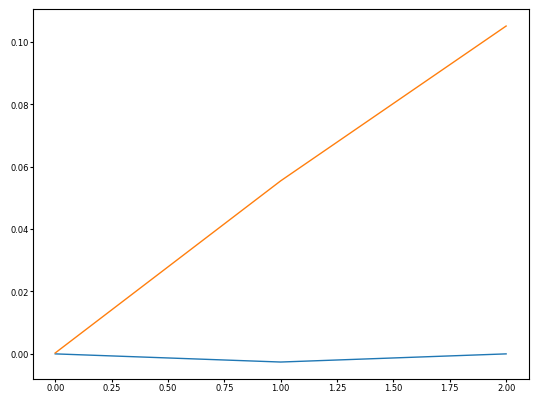

In [63]:
plt.plot(var_by_coupling_percentage_matrix.mean(axis=1))
plt.plot(var_by_coupling_percentage_matrix_base_model.mean(axis=1))

# Reduced rank regression

In [64]:
####### Reduced Rank Regression ########
from GLM import reduced_rank_regression
num_trials_to_use = 2000
merge_time = 25
var_by_coupling_percentage_matrix_rrr = np.zeros((len(shared_background_list), nrep))
for i_shared_background, shared_background in enumerate(shared_background_list):
    for rep in range(nrep):

        load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'

        data = np.load(load_data_name, allow_pickle=True)
        spikes = data['spikes'][:, :, :num_trials_to_use]
        trial_info = data['trial_info']
        I_ext = data['I_ext']
        I_syn = data['I_syn']
        nt, nneuron, ntrial = spikes.shape

        spikes_merged = spikes.reshape(
            int(nt/merge_time), 
            merge_time, 
            nneuron, 
            ntrial
        ).sum(axis=1)
        X = spikes_merged[:, :50, :]
        Y = spikes_merged[:, 50:, :]
        var_by_coupling_percentage_matrix_rrr[i_shared_background, rep] = (
            reduced_rank_regression(X, Y, 1)
        )

# Save the variance explained matrices
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_rrr.npy', 
        var_by_coupling_percentage_matrix_rrr)


# Single-neuron GLM

In [106]:
######### Single-neuron GLM ##########
# Randomly sample some neurons in area 2 and fit the model
num_trials_to_use = 200
from GLM import PP_GLM
var_by_coupling_percentage_matrix_single_neuron_GLM = np.zeros((len(shared_background_list), nrep))

for i_shared_background, shared_background in enumerate(shared_background_list):
    for rep in range(1):
        load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'

        data = np.load(load_data_name, allow_pickle=True)
        spikes = data['spikes'][:, :, :num_trials_to_use]
        trial_info = data['trial_info']
        I_ext = data['I_ext']
        I_syn = data['I_syn']
        nt, nneuron, ntrial = spikes.shape

        all_trials = np.array( [True]*ntrial )
        var_list = []
        for output_neuron in tqdm(range(nneuron_part, 2*nneuron_part)):
            model = PP_GLM(ntrial=ntrial, nt=nt, select_trials=all_trials)
            model.add_effect("inhomogeneous_baseline", num=20, apply_no_penalty=True)
            for input_neuron in range(nneuron):
                model.add_effect("coupling", raw_input=spikes[:,input_neuron,:], 
                                num=3, peaks_max=5, nonlinear=1)
            model.fit(target=spikes[:,output_neuron,:], method='mine', penalty=1e0, verbose=False)
            var_by_all_predictors = (np.exp(model.predictors@model.results.params)).var()
            params_not_coupling = np.concatenate([np.arange(20), np.arange(20+3*nneuron_part, 20+6*nneuron_part)])
            var_wo_coupling = (
                np.exp(model.predictors[:,params_not_coupling]@model.results.params[params_not_coupling])
            ).var()
            var_list.append((var_by_all_predictors - var_wo_coupling) / var_by_all_predictors)
        var_by_coupling_percentage_matrix_single_neuron_GLM[i_shared_background, rep] = (
            np.mean(var_list)
        )

# Save the variance explained matrices
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_single_neuron_GLM.npy', 
        var_by_coupling_percentage_matrix_single_neuron_GLM)


100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


In [135]:
params_coupling = np.concatenate([np.arange(20, 20+nneuron_part)])
params_not_coupling = np.concatenate([np.arange(20), np.arange(20+nneuron_part, 20+2*nneuron_part)])

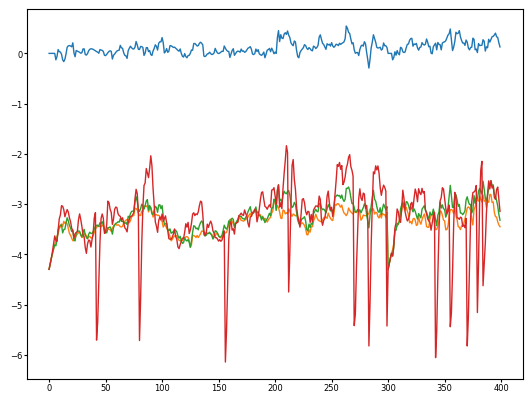

In [139]:
aaa = (model.predictors[:, params_coupling]@model.results.params[params_coupling])[:400]
bbb = (model.predictors[:, params_not_coupling]@model.results.params[params_not_coupling])[:400]
plt.plot(aaa)
plt.plot(bbb)
plt.plot(aaa+bbb)
plt.plot((model.predictors@model.results.params)[:400])

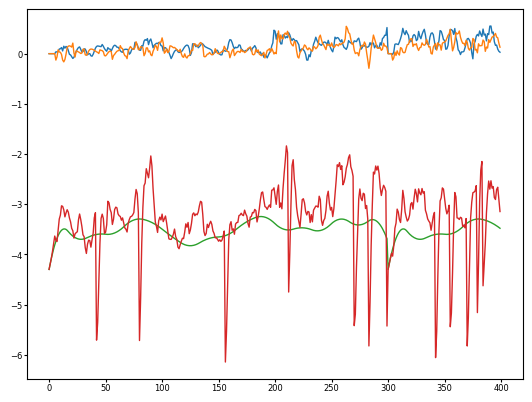

In [134]:
plt.plot((model.predictors[:,params_not_coupling1]@model.results.params[params_not_coupling1])[:400], label='coupling')
plt.plot((model.predictors[:,params_not_coupling2]@model.results.params[params_not_coupling2])[:400], label='no coupling')
plt.plot((model.predictors[:, :20]@model.results.params[:20])[:400], label='all')
plt.plot((model.predictors@model.results.params)[:400], label='all')

In [113]:
(np.exp(model.predictors@model.results.params)).var()

0.0024382970905617164

In [107]:
var_by_coupling_percentage_matrix_single_neuron_GLM

array([[0.98417041, 0.        , 0.        , 0.        , 0.        ],
       [0.985178  , 0.        , 0.        , 0.        , 0.        ],
       [0.98835952, 0.        , 0.        , 0.        , 0.        ]])

# Single-neuron GLM with trial-specific gain

In [ ]:
######### Single-neuron GLM ##########
# Randomly sample some neurons in area 2 and fit the model
num_trials_to_use = 200

from GLM import PP_GLM
var_by_coupling_percentage_matrix_single_neuron_GLM_gain = np.zeros((len(shared_background_list), nrep))

for i_shared_background, shared_background in enumerate(shared_background_list):
    for rep in range(nrep):
        load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'

        data = np.load(load_data_name, allow_pickle=True)
        spikes = data['spikes'][:, :, :num_trials_to_use]
        trial_info = data['trial_info']
        I_ext = data['I_ext']
        I_syn = data['I_syn']
        nt, nneuron, ntrial = spikes.shape

        all_trials = np.array( [True]*ntrial )
        var_list = []
        for output_neuron in tqdm(range(nneuron_part, 2*nneuron_part)):
            model = PP_GLM(ntrial=ntrial, nt=nt, select_trials=all_trials)
            model.add_effect("trial_coef")
            model.add_effect("inhomogeneous_baseline", num=20, apply_no_penalty=True)
            for input_neuron in range(nneuron):
                model.add_effect("coupling", raw_input=spikes[:,input_neuron,:], 
                                num=3, peaks_max=5, nonlinear=1)
            model.fit(target=spikes[:,input_neuron,:], method='mine', penalty=1e-10, verbose=False)
            var_by_all_predictors = (np.exp(model.predictors@model.results.params)).var()
            params_not_coupling = np.arange(20) + np.arange(20+nneuron_part, 20+2*nneuron_part)
            var_wo_coupling = (
                np.exp(model.predictors[:,params_not_coupling]@model.results.params[params_not_coupling])
            ).var()
            var_list.append((var_by_all_predictors - var_wo_coupling) / var_by_all_predictors)
        var_by_coupling_percentage_matrix_single_neuron_GLM_gain[i_shared_background, rep] = (
            np.mean(var_list)
        )

# Save the variance explained matrices
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_single_neuron_GLM_gain.npy', 
        var_by_coupling_percentage_matrix_single_neuron_GLM_gain)


100%|██████████| 50/50 [02:01<00:00,  2.44s/it]


# Plot

In [70]:
### Load results
var_by_coupling_percentage_matrix = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix.npy'
)
var_by_coupling_percentage_matrix_base_model = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_base_model.npy'
)
var_by_coupling_percentage_matrix_rrr = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_rrr.npy'
)
var_by_coupling_percentage_matrix_single_neuron_GLM = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_single_neuron_GLM.npy'
)
var_by_coupling_percentage_matrix_single_neuron_GLM_gain = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_single_neuron_GLM_gain.npy'
)


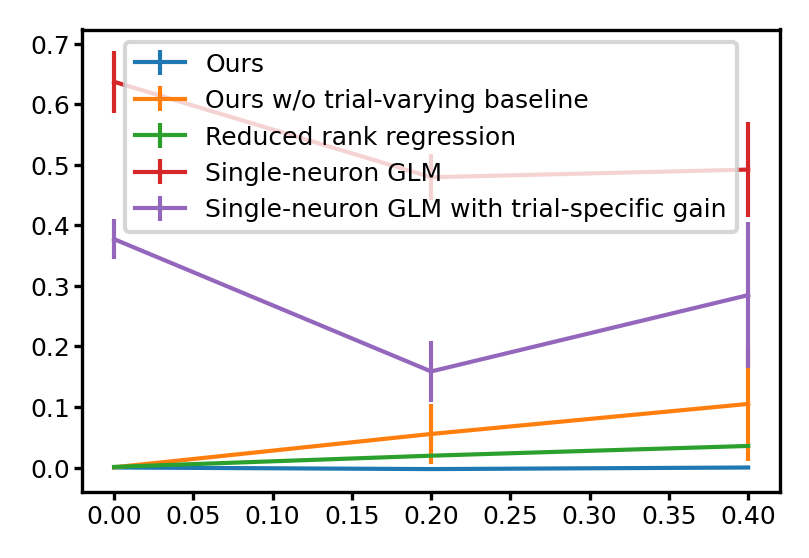

In [87]:
utils.use_pdf_plot()
fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=300)

for results in [
    var_by_coupling_percentage_matrix,
    var_by_coupling_percentage_matrix_base_model,
    var_by_coupling_percentage_matrix_rrr,
    var_by_coupling_percentage_matrix_single_neuron_GLM,
    var_by_coupling_percentage_matrix_single_neuron_GLM_gain
]:
    plt.errorbar(shared_background_list, results.mean(axis=1), results.std(axis=1)/np.sqrt(results.shape[1]))

plt.legend([
    "Ours",
    "Ours w/o trial-varying baseline",
    "Reduced rank regression",
    "Single-neuron GLM",
    "Single-neuron GLM with trial-specific gain",
])